In [4]:
# import packages
import numpy as np
import jax.scipy as jsp # boost computation
import matplotlib.pyplot as plt
import imageio
from os import listdir

In [5]:
# interactive plotting
%matplotlib notebook
%matplotlib notebook

# Yale Faces B

## Function Definition

### Batch import images

In [847]:
def imread_batch(folder, mode = 'Stack', fname_spec = None):
    '''
    Batch import static images, 2 modes available.
    Input:
        folder: (String) directory name
        mode: 'Stack' or 'Avg'
            'Stack': Stack images of each face as a matrix
            'Avg': Take average of images of each face as a column vector
        fname_spec: (String) specify what is contained in filename
    Output:
        return a 2d numpy matrix with reshaped images as column vectors
    '''
    
    # sanity check on mode
    if (mode != 'Stack') and (mode != 'Avg'):
        print('Error: incorrect mode. Choose between "Stack" or "Avg". ')
        return
    
    # sanity check on folder name
    if folder.endswith('/') == False:
        folder = folder + '/'
    
    # fetch a list of filenames
    if fname_spec == None:
        # assume all files in folder are images
        fnames = sorted(listdir(folder))
    else:
        fnames = list(fname for fname in sorted(listdir(folder)) if fname_spec in fname)
        if len(fnames) == 0:
            print('Error: No file name contains ' + str(fname_spec))
            return
    
    # determine the dimensions of each image
    temp = imageio.imread(folder + fnames[0])
    idx = temp.shape
    img_num = len(fnames)
    
    # initialize
    img_temp = np.zeros((idx[0]*idx[1], img_num))
    for i in range(img_num):
        # assume the image is in grayscale
        img = imageio.imread(folder + fnames[i])
        img = img.reshape(idx[0]*idx[1])
        img_temp[:,i] = img
    
    # Average mode
    if mode == 'Avg':
        img_data = np.zeros((idx[0]*idx[1], 1))
        img_data[:,0] = img_temp.mean(axis = 1)
        
    # Stack mode
    elif mode == 'Stack':
        img_data = img_temp
        
    return img_data

In [848]:
def imread_batch_multidir(folder, mode = 'Stack', fname_spec = None, dirname_spec = None):
    '''
    Batch import static images from multiple directories in folder, 2 modes available.
    Input:
        folder: (String) directory name
        mode: 'Stack' or 'Avg'
            'Stack': Stack images of each face as a matrix
            'Avg': Take average of images of each face as a column vector
        fname_spec: (String) specify what is contained in filename
        dirname_spec: (String) specify what is contained in directory name
    Output:
        return a 2d numpy matrix with reshaped images as column vectors
    '''
    
    # sanity check on mode
    if (mode != 'Stack') and (mode != 'Avg'):
        print('Error: incorrect mode. Choose between "Stack" or "Avg". ')
        return
    
    # sanity check on folder name
    if folder.endswith('/') == False:
        folder = folder + '/'
    
    # fetch a list of directory names
    if dirname_spec == None:
        # assume all items in folder are directories
        dirnames = sorted(listdir(folder))
    else:
        dirnames = list(dirname for dirname in sorted(listdir(folder)) if dirname_spec in dirname)
        if len(dirnames) == 0:
            print('Error: No directory name contains ' + str(dirname_spec))
            return
    
    # avoid ambiguity when passing arguments
    str1, str2 = mode, fname_spec
    
    # Batch import images in each folder
    img_data = imread_batch(folder + dirnames[0], mode = str1, fname_spec = str2)
    for i in range(1, len(dirnames)):
        data = imread_batch(folder + dirnames[i], mode = str1, fname_spec = str2)
        img_data = np.concatenate((img_data, data), axis = 1)
    
    return img_data

### Face reconstruction

In [849]:
def face_reconstruct(u, s, vh, face_no, faces_num = 64, rank = 10, reshape = False, dims = [192, 168], mode = 'Avg'):
    '''
    Reconstruct a specified face by low rank approximation out of SVD
    Input:
        u, s, vh: svd of original faces
        face_no: specify which face to reconstruct
        faces_num: number of images based on the specified face
        rank: number of modes used to reconstruct
        reshape: whether to reshape the vector to a matrix for image
        dims: (list) [length pixels, width pixels]
        mode: 'Avg' or 'Single'
    Output:
        return a vector/reshaped matrix of face
    '''
    
    ur = u[:,0:rank]
    sr = np.diag(s[0:rank])
    vhr = vh[0:rank, faces_num*(face_no-1):faces_num*face_no]
    faces_approx = np.linalg.multi_dot([ur, sr, vhr])
    if mode == 'Single':
        face_approx = faces_approx[:,0]
    else: # average
        face_approx = faces_approx.mean(axis = 1)
    
    if reshape == True:
        face_approx = face_approx.reshape(dims[0], dims[1])
    
    return face_approx

In [850]:
def face_reconstruct_plot(u, s, vh, face_no, dir_origin, faces_amount = 64, rank_list = [10, 20, 50, 100, 200], fname_spec = None, dims = [192, 168]):
    '''
    Plot original face & reconstructed faces by low rank approximation
    Input:
        u, s, vh: svd of original faces
        face_no: specify which face to reconstruct
        dir_origin: (String) location of original face
        faces_amount: amount of images for each face
        rank_list: (list) list of rank used
        fname_spec: (String) specify what is contained in filename
        dims: (list) [length pixels, width pixels]
    Output:
        plot images
        return nothing
    '''
    
    # fetch the data of original face
    if fname_spec: 
        str1 = fname_spec # avoid ambiguous
        face_origin = imread_batch(dir_origin, mode = 'Avg', fname_spec = str1)
    else:
        face_origin = imread_batch(dir_origin, mode = 'Avg')
    face_origin = face_origin.reshape(dims[0], dims[1])
    
    # plot original
    plt.figure(figsize = (10,6))
    plt.subplot(2,3,1)
    plt.imshow(face_origin, cmap = plt.get_cmap("gray"))
    plt.title('Original face')
    plt.axis('off')
    
    for i in range(len(rank_list)):
        
        # compute reconstructed face
        face_approx = face_reconstruct(u, s, vh, face_no, faces_num = faces_amount, rank = rank_list[i], reshape = True, dims = dims)
        # plot reconstructed face
        plt.subplot(2,3,i+2)
        plt.imshow(face_approx, cmap = plt.get_cmap("gray"))
        plt.title('rank = %d' % rank_list[i])
        plt.axis('off')
        
    plt.show()
    
    return

In [851]:
def face_reconstruct_plot_s(u, s, vh, face_no, dir_origin, faces_amount = 64, rank = 200, fname_spec = None, dims = [192, 168]):
    '''
    Plot original face & reconstructed faces by low rank approximation (simple, only 1 rank)
    Input:
        u, s, vh: svd of original faces
        face_no: specify which face to reconstruct
        dir_origin: (String) location of original face
        faces_amount: amount of images for each face
        fname_spec: (String) specify what is contained in filename
        dims: (list) [length pixels, width pixels]
    Output:
        plot images
        return nothing
    '''
    
    # fetch the data of original face
    if fname_spec: 
        str1 = fname_spec # avoid ambiguous
        face_origin = imread_batch(dir_origin, mode = 'Stack', fname_spec = str1)
        face_origin = face_origin[:,0]
    else:
        face_origin = imread_batch(dir_origin, mode = 'Avg')
    face_origin = face_origin.reshape(dims[0], dims[1])
    
    # compute reconstructed face for first expression
    face_approx_s = face_reconstruct(u, s, vh, face_no, faces_num = faces_amount, rank = rank, reshape = True, dims = dims, mode = 'Single')
    # compute reconstructed face averaged over expressions
    face_approx_a = face_reconstruct(u, s, vh, face_no, faces_num = faces_amount, rank = rank, reshape = True, dims = dims, mode = 'Avg')
    
    # plot original
    plt.figure(figsize = (10,3))
    plt.subplot(1,3,1)
    plt.imshow(face_origin, cmap = plt.get_cmap("gray"))
    plt.title('Original face')
    plt.axis('off')
    
    # plot reconstructed face
    plt.subplot(1,3,2)
    plt.imshow(face_approx_s, cmap = plt.get_cmap("gray"))
    plt.title('First expression, rank = %d' % rank)
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(face_approx_a, cmap = plt.get_cmap("gray"))
    plt.title('Averaged expressions, rank = %d' % rank)
    plt.axis('off')
        
    plt.show()
    
    return

## Cropped images

dataset description: 38 faces * 64 images (192 pixels * 168 pixels)

### SVD

In [852]:
img_crop = imread_batch_multidir('CroppedYale/', mode = 'Stack', dirname_spec = 'yale')

In [853]:
%%time
u_crop_fast, s_crop_fast, vh_crop_fast = jsp.linalg.svd(img_crop, full_matrices = False)

CPU times: user 228 ms, sys: 176 ms, total: 404 ms
Wall time: 539 ms


In [854]:
%%time
u_crop = np.asarray(u_crop_fast)
s_crop = np.asarray(s_crop_fast)
vh_crop = np.asarray(vh_crop_fast)

CPU times: user 22.5 s, sys: 692 ms, total: 23.2 s
Wall time: 13.7 s


<IPython.core.display.Javascript object>


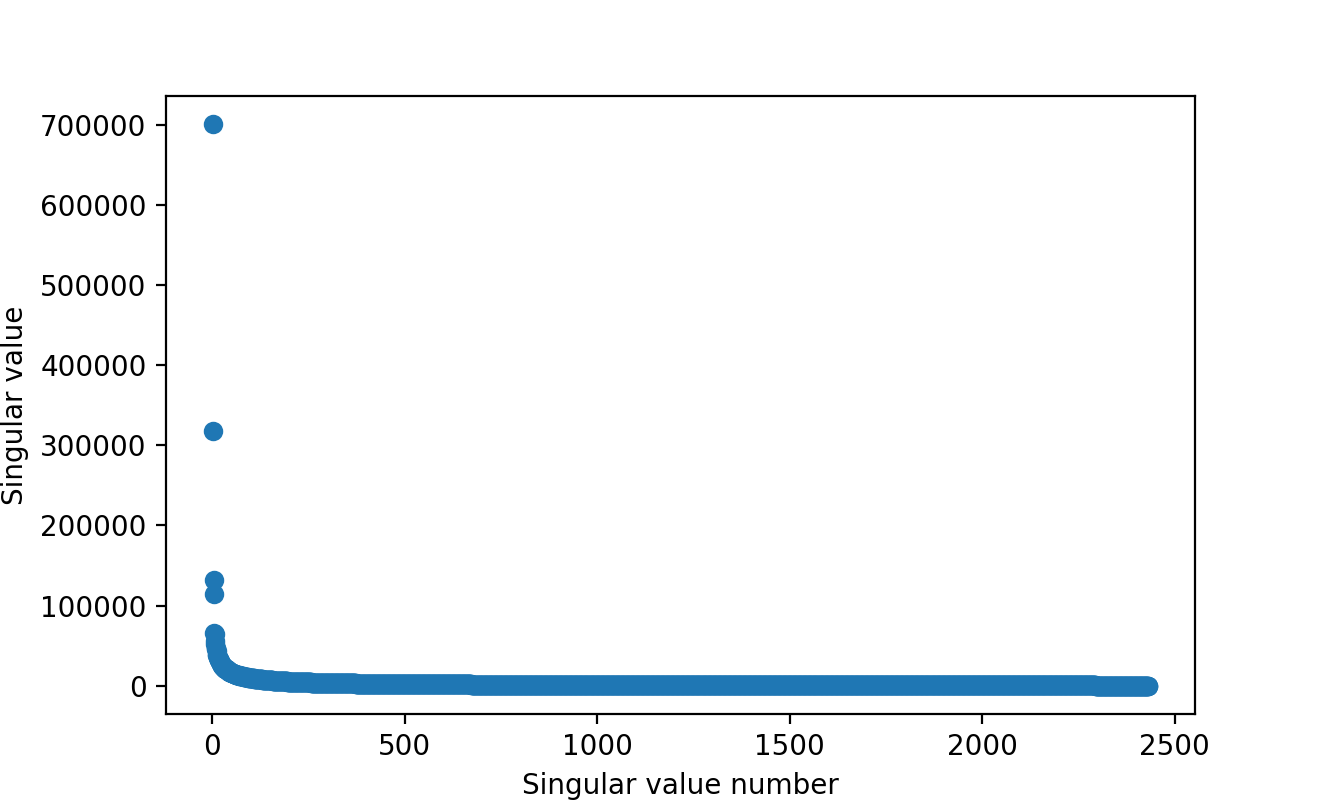

In [856]:
# plot singular values on eigenfaces
plt.figure(1, figsize = (6,4))
#plt.subplot(1,2,1)
plt.scatter(np.arange(1,len(s_crop)+1), s_crop)
plt.xlabel('Singular value number')
plt.ylabel('Singular value')
#plt.subplot(1,2,2)
#plt.semilogy(s_crop)
#plt.xlabel('Singular value number')
#plt.ylabel('Singular value')
plt.show()

<IPython.core.display.Javascript object>


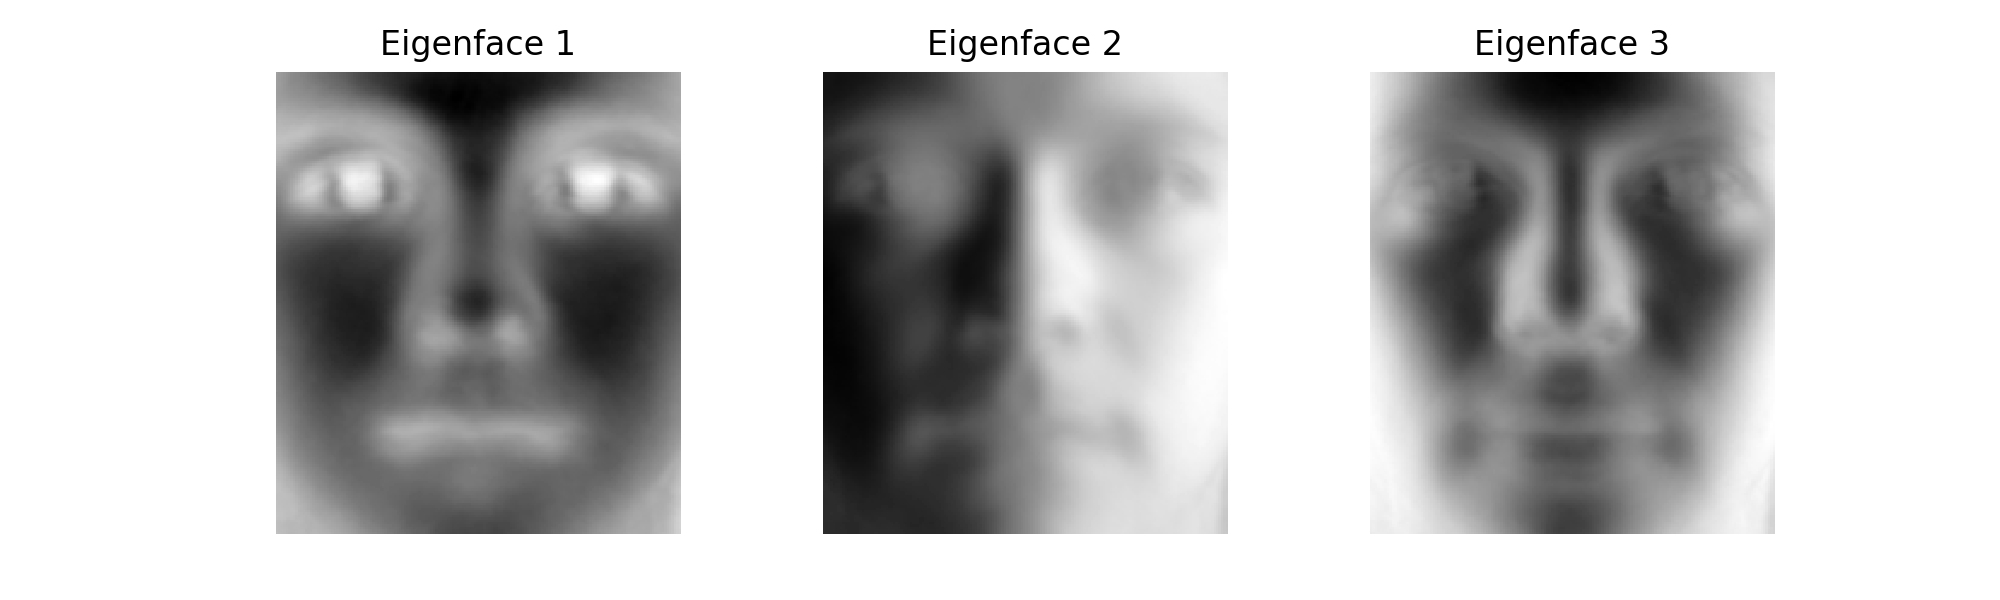

In [857]:
# plot eigenfaces
plt.figure(2, figsize = (10,3))
plt.subplot(1,3,1)
plt.imshow((u_crop[:,0]).reshape(192, 168), cmap = plt.get_cmap("gray"))
plt.title('Eigenface 1')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow((u_crop[:,1]).reshape(192, 168), cmap = plt.get_cmap("gray"))
plt.title('Eigenface 2')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow((u_crop[:,2]).reshape(192, 168), cmap = plt.get_cmap("gray"))
plt.title('Eigenface 3')
plt.axis('off')
plt.show()

<IPython.core.display.Javascript object>


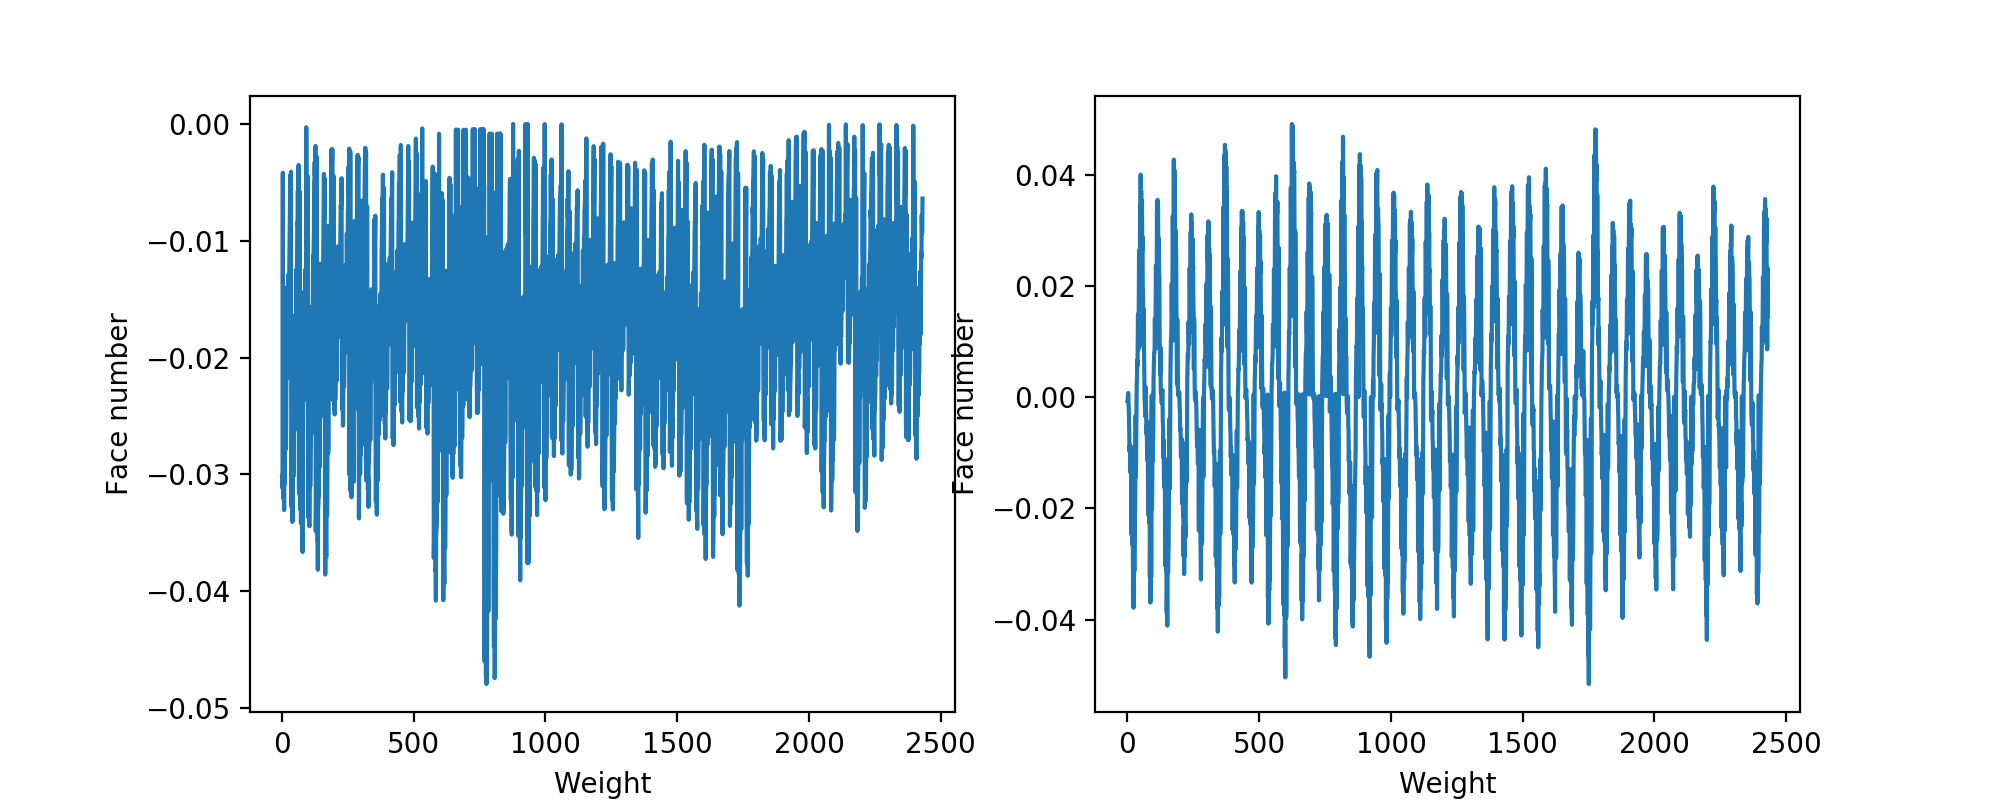

In [863]:
# plot projection of faces onto eigenfaces
plt.figure(3, figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(vh_crop[0])
plt.xlabel('Weight')
plt.ylabel('Face number')
plt.subplot(1,2,2)
plt.plot(vh_crop[1])
plt.xlabel('Weight')
plt.ylabel('Face number')
#plt.subplot(1,3,3)
#plt.plot(vh_crop[2])
plt.show()

### Reconstruct faces

SVD:
$$
\begin{aligned}
A &= U\Sigma V \\
A &= \sum_{i} \sigma_{ii} u_i v^*_i \\
a_{ij} &= u_{ik}\sigma_{kk}v^*_{kj}.
\end{aligned}
$$

A column vector represents an image of face. The $j$th column of $A$ satisfies
$$
a_j = U\Sigma (V^*)_j.
$$
Here $(V^*)_j$ is the $j$th column of $V^*$, the Hermitian of $V$. 

Full rank reconstruction to images regarding the $n$th face is
$$
\begin{aligned}
A_{(64n-63):64n} &= U\Sigma (V^*)_{(64n-63):64n} \\
A_{(64n-63):64n} &= \sum_{i} \sigma_{ii} u_i v^*_{i,(64n-63):64n}.
\end{aligned}
$$

The low rank approximation to images regarding the $n$th face is
$$
A_{r,(64n-63):64n} = \sum_{i=1}^r \sigma_{ii} u_i v^*_{i,(64n-63):64n}
$$
with rank $r$.

I want to merge those images into one single image for the $n$th face in order to display. Therefore, I'll merge the columns of $A$ by taking average.

<IPython.core.display.Javascript object>


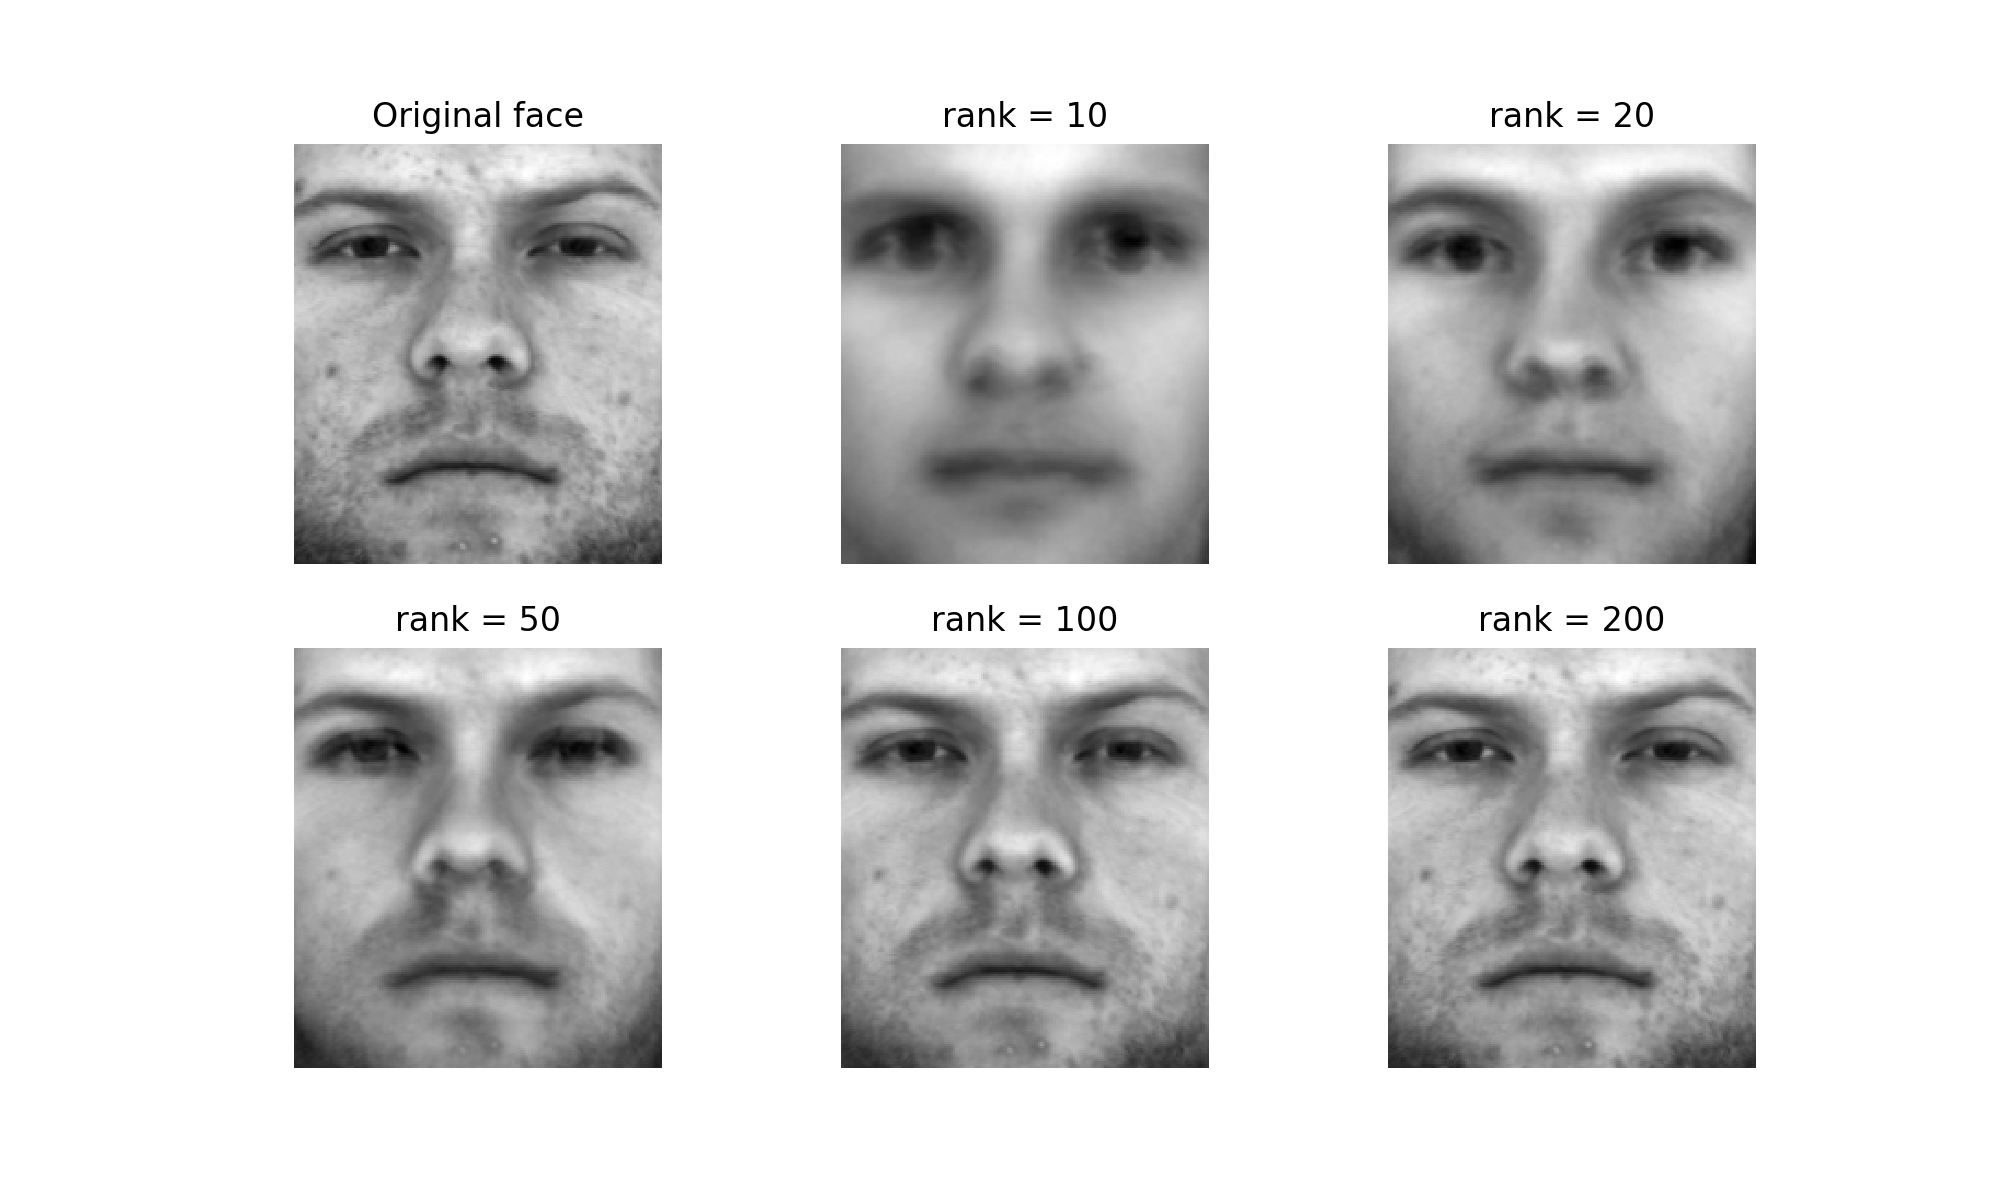

In [864]:
# plot reconstructed faces versus the original
face_reconstruct_plot(u_crop, s_crop, vh_crop, 1, 'CroppedYale/yaleB01', rank_list = [10, 20, 50, 100, 200])

## Uncropped images

dataset description: 15 faces * 11 expressions (243 pixels * 320 pixels)

### SVD

In [866]:
img_uncrop = imread_batch('yalefaces_uncropped/yalefaces/')

In [867]:
%%time
u_uncrop_fast, s_uncrop_fast, vh_uncrop_fast = jsp.linalg.svd(img_uncrop, full_matrices = False)

CPU times: user 80.9 ms, sys: 27.6 ms, total: 109 ms
Wall time: 138 ms


In [868]:
%%time
u_uncrop = np.asarray(u_uncrop_fast)
s_uncrop = np.asarray(s_uncrop_fast)
vh_uncrop = np.asarray(vh_uncrop_fast)

CPU times: user 750 µs, sys: 6.63 ms, total: 7.38 ms
Wall time: 7.49 ms


<IPython.core.display.Javascript object>


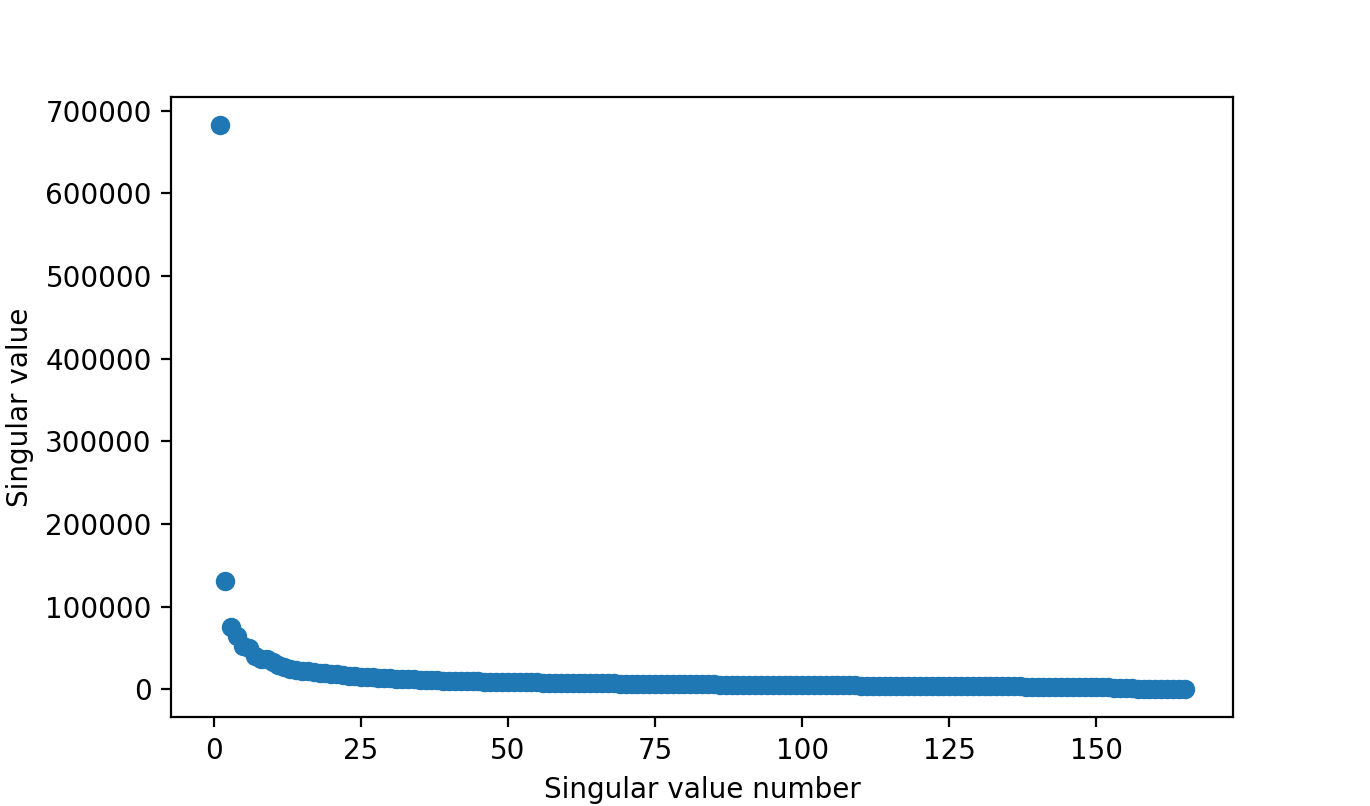

In [870]:
# plot singular values on eigenfaces
plt.figure(11, figsize = (6,4))
#plt.subplot(1,2,1)
plt.scatter(np.arange(1,len(s_uncrop)+1), s_uncrop)
plt.xlabel('Singular value number')
plt.ylabel('Singular value')
#plt.subplot(1,2,2)
#plt.semilogy(s_uncrop)
#plt.xlabel('Singular value number')
#plt.ylabel('Singular value')
plt.show()

<IPython.core.display.Javascript object>


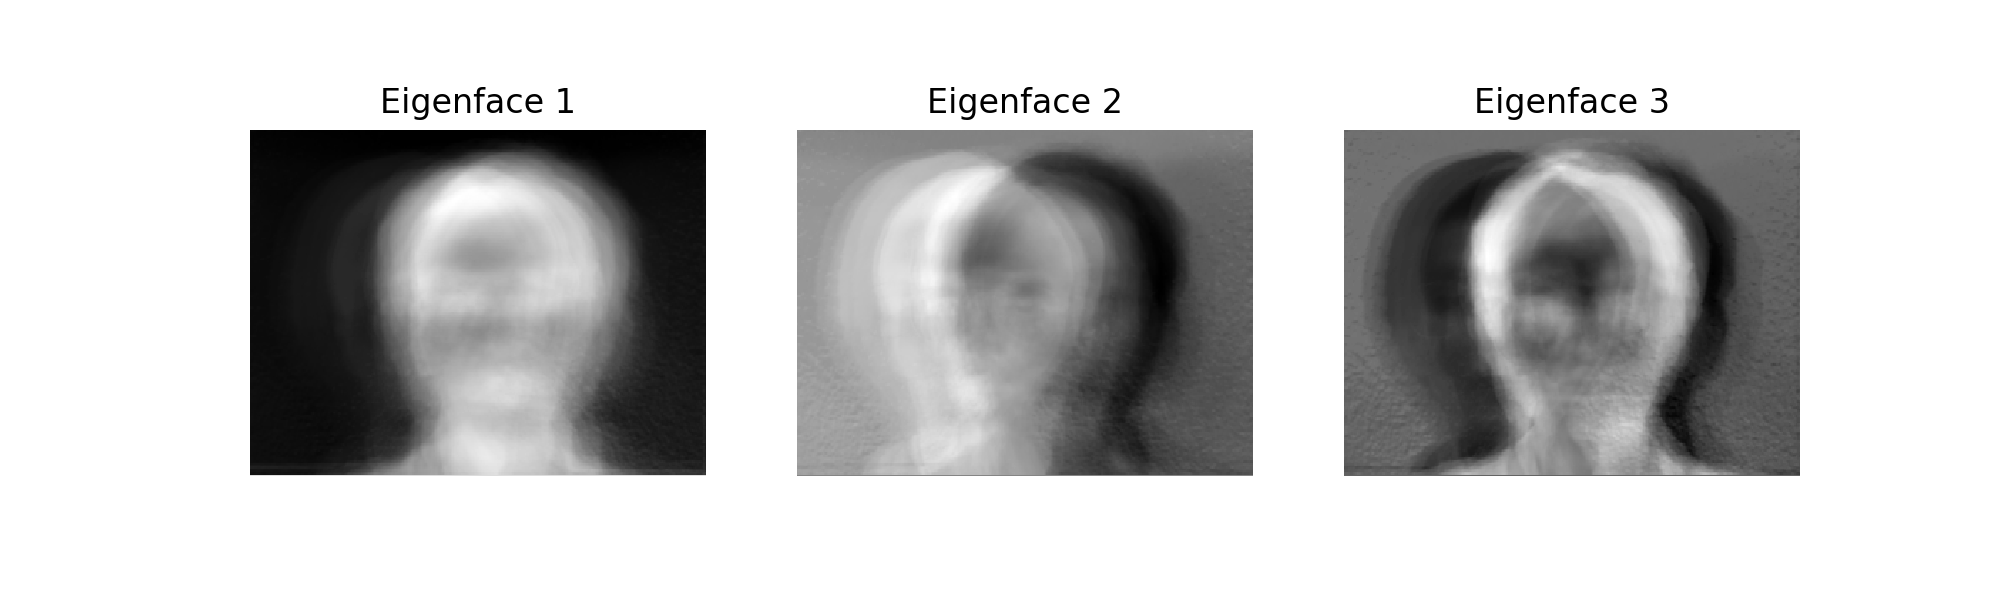

In [872]:
# plot eigenfaces
plt.figure(12, figsize = (10,3))
plt.subplot(1,3,1)
plt.imshow((u_uncrop[:,0]).reshape(243, 320), cmap = plt.get_cmap("gray"))
plt.title('Eigenface 1')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow((u_uncrop[:,1]).reshape(243, 320), cmap = plt.get_cmap("gray"))
plt.title('Eigenface 2')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow((u_uncrop[:,2]).reshape(243, 320), cmap = plt.get_cmap("gray"))
plt.title('Eigenface 3')
plt.axis('off')
plt.show()

<IPython.core.display.Javascript object>


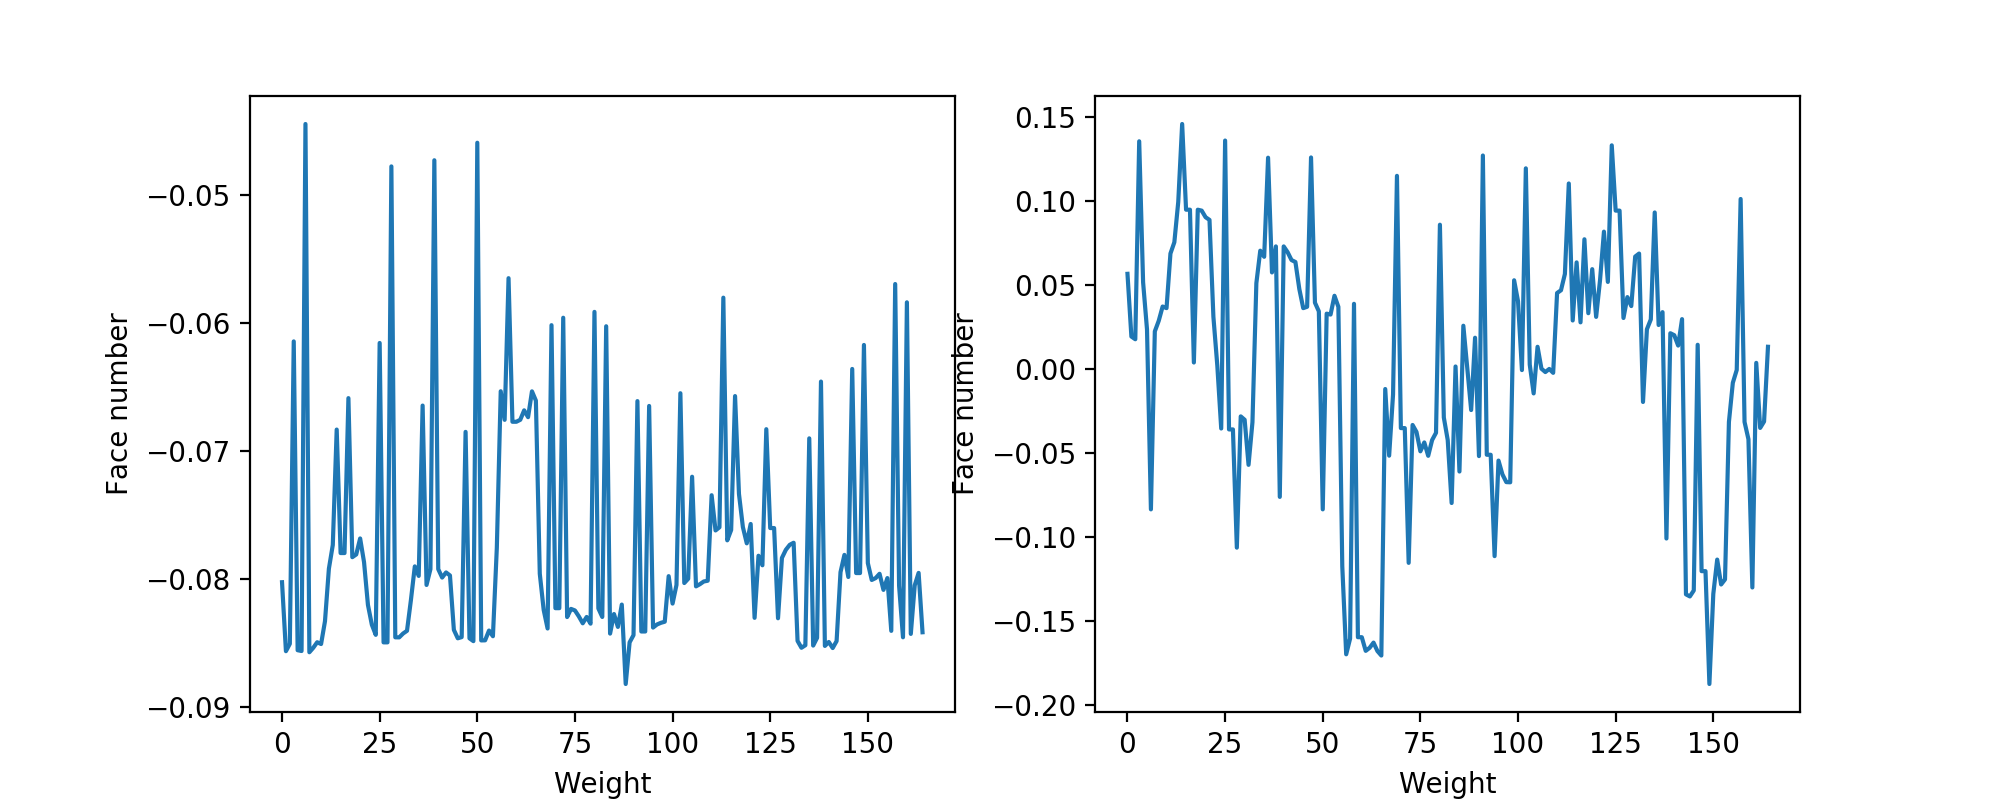

In [875]:
# plot projection of faces onto eigenfaces
plt.figure(13, figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(vh_uncrop[0])
plt.xlabel('Weight')
plt.ylabel('Face number')
plt.subplot(1,2,2)
plt.plot(vh_uncrop[1])
plt.xlabel('Weight')
plt.ylabel('Face number')
#plt.subplot(1,3,3)
#plt.plot(vh_uncrop[2])
plt.show()

### Reconstruct faces

For this case, full rank reconstruction to images regarding the $n$th face is
$$
\begin{aligned}
A_{(11n-10):11n} &= U\Sigma (V^*)_{(11n-10):11n} \\
A_{(11n-10):11n} &= \sum_{i} \sigma_{ii} u_i v^*_{i,(11n-10):11n}.
\end{aligned}
$$

The low rank approximation to images regarding the $n$th face is
$$
A_{r,(11n-10):11n} = \sum_{i=1}^r \sigma_{ii} u_i v^*_{i,(11n-10):11n}
$$
with rank $r$.

I want to merge those images into one single image for the $n$th face in order to display. Therefore, I'll merge the columns of $A$ by taking average.

<IPython.core.display.Javascript object>


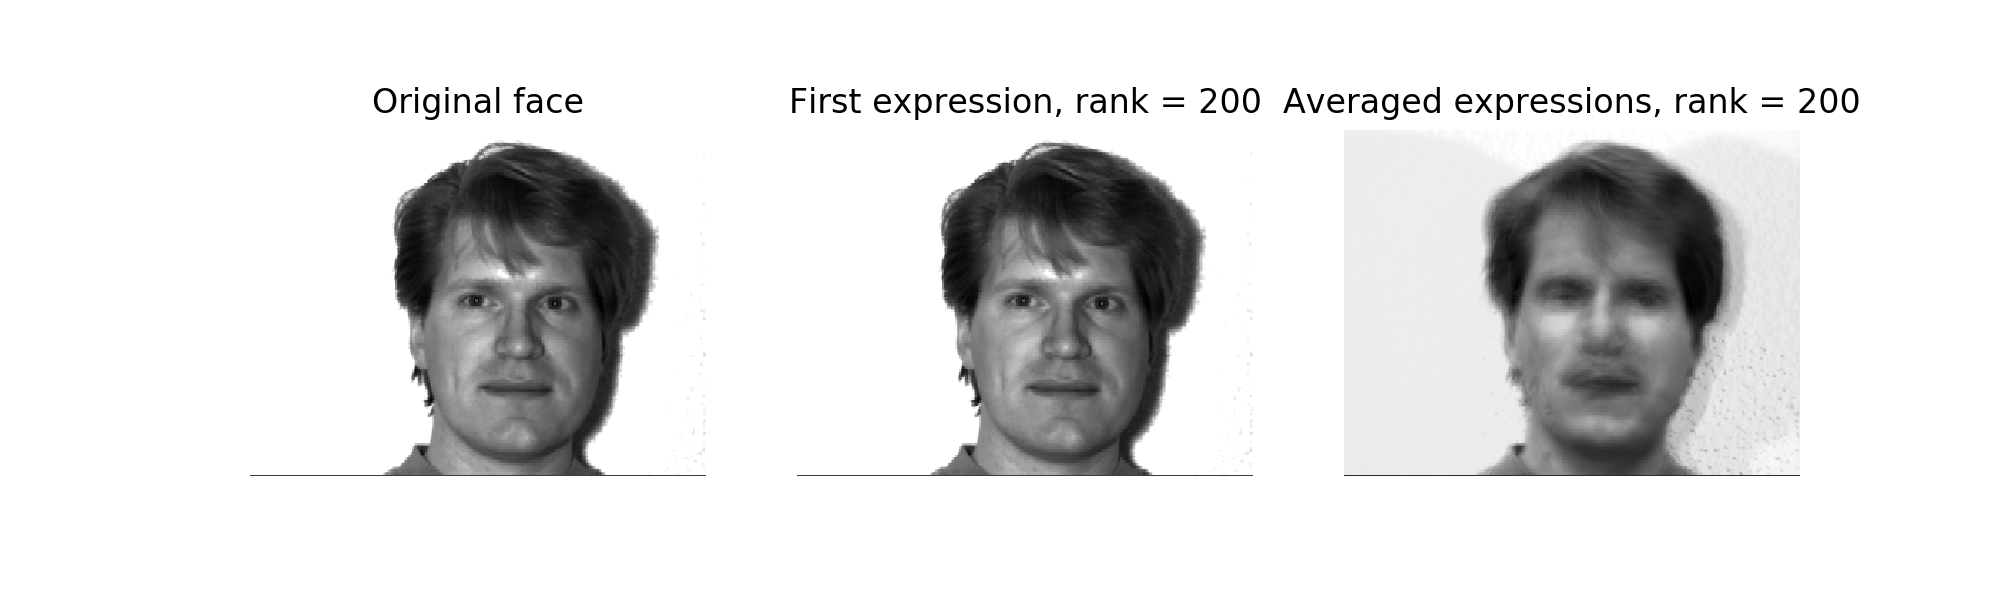

In [273]:
# plot reconstructed faces versus the original
face_reconstruct_plot_s(u_uncrop, s_uncrop, vh_uncrop, 1, 'yalefaces_uncropped/yalefaces/', faces_amount = 11\
                      , fname_spec = 'subject01', dims = [243, 320])

<IPython.core.display.Javascript object>


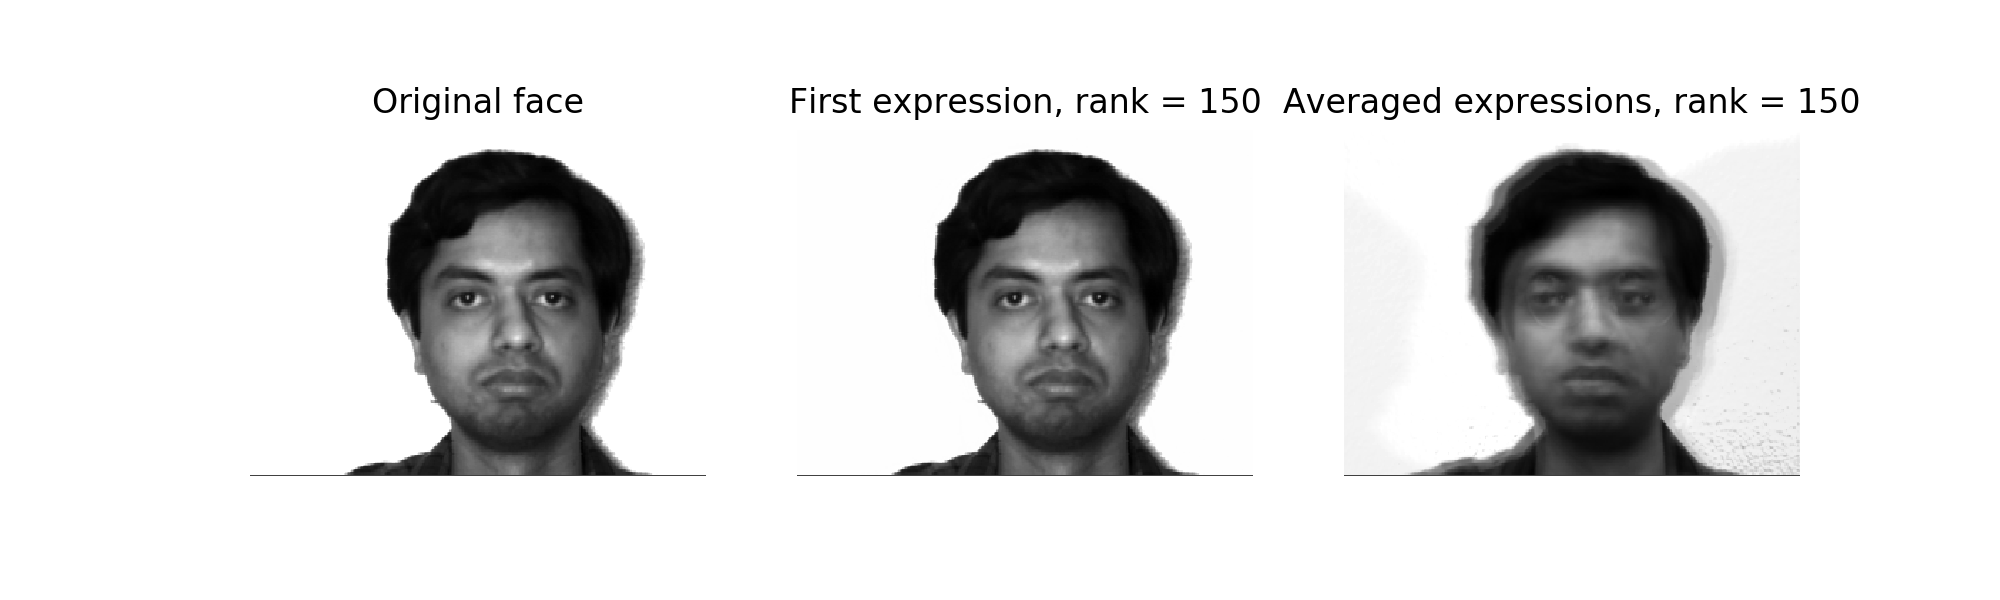

In [265]:
# plot reconstructed faces versus the original
face_reconstruct_plot_s(u_uncrop, s_uncrop, vh_uncrop, 10, 'yalefaces_uncropped/yalefaces/', faces_amount = 11\
                      , fname_spec = 'subject10', dims = [243, 320])

<IPython.core.display.Javascript object>


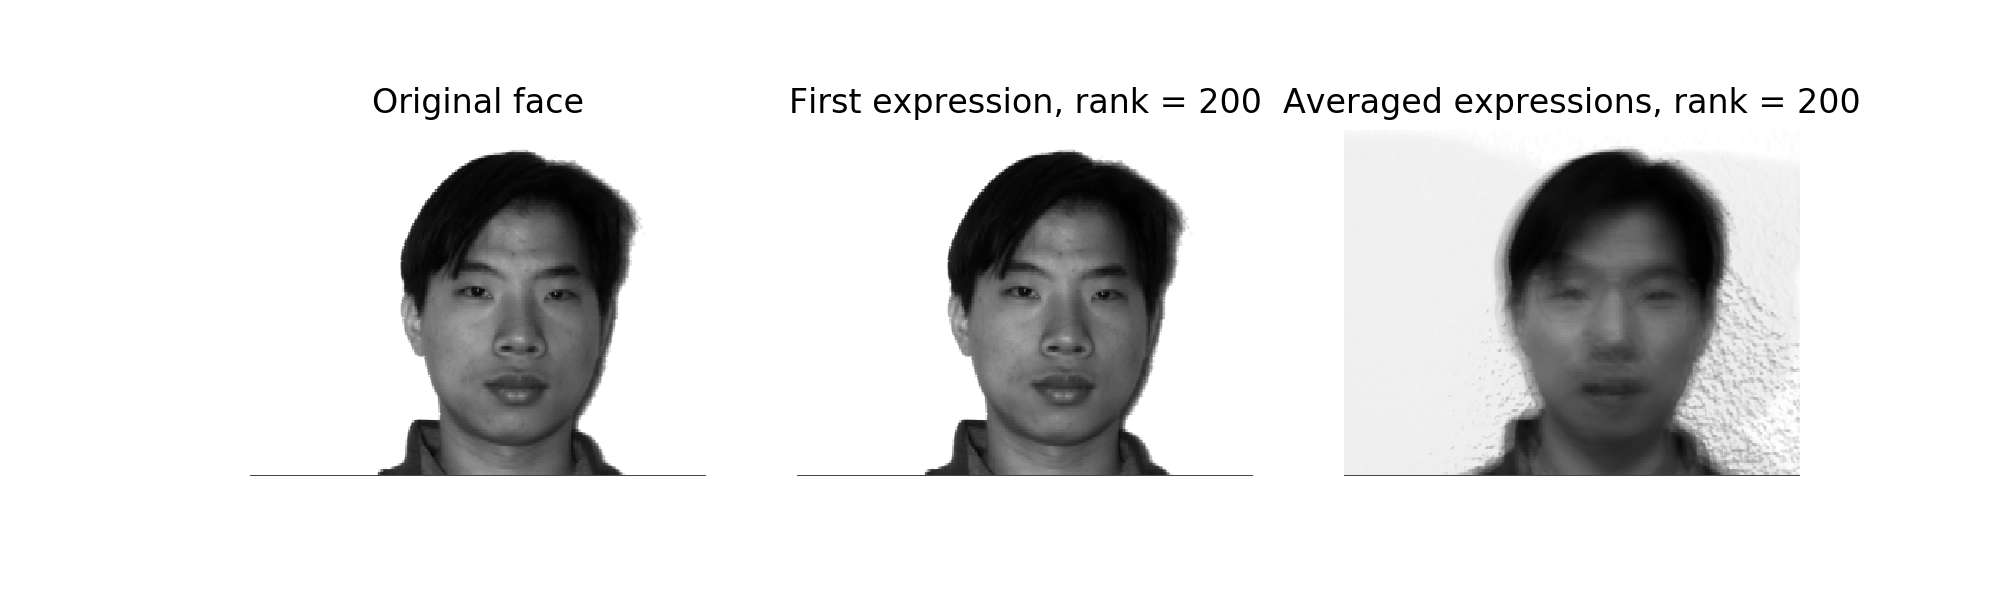

In [274]:
# plot reconstructed faces versus the original
face_reconstruct_plot_s(u_uncrop, s_uncrop, vh_uncrop, 4, 'yalefaces_uncropped/yalefaces/', faces_amount = 11\
                      , fname_spec = 'subject04', dims = [243, 320])

# Music Classification

In [207]:
# import packages
from pydub import AudioSegment
from scipy.io import wavfile
from scipy import signal

## Batch import & process music piece

In [194]:
def mp3read(fname, resample_rate = None):
    '''
    Import mp3 music piece
    Input:
        fname: (String) file name
    Output:
        return a numpy array of music
    '''
    
    song = AudioSegment.from_mp3(fname)
    if resample_rate:
        song = song.set_frame_rate(resample_rate)
    
    fname_new = fname[:-4] + '.wav'
    song.export(fname_new, format = 'wav')
    fs, data = wavfile.read(fname_new)
    
    # merge sound channels
    if data.shape[1] == 2:
        data = data.mean(axis = 1)
    
    return fs, data

In [169]:
def data_crop(data):
    '''
    Crop out beginning and end when there's no sound
    Input:
        data: (Numpy Array) music piece
    Output: 
        return a numpy array of music
    '''
    
    thres = abs(data).mean() / 20
    idx = np.where(abs(data) >= thres)[0]
    data_c = data[idx[0]:idx[-1]].copy()
    
    return data_c

In [189]:
def data_5sec_init(fs, data, num):
    '''
    Extract multiple 5-sec-sound-pieces from data
    Input:
        fs: (int) sampling rate
        data: (Numpy Array) music piece longer than 5 seconds
        num: (int) number of music pieces extracted
    Output: 
        return a 2d numpy array (column = each sound piece)
    '''
    
    # dimension
    data_len = data.shape[0]
    
    # sanity check
    if data_len <= fs*5:
        print('Error: Music piece must be longer than 5 seconds. ')
        return
    if isinstance(num, int) != True:
        print('Error: Invalid # of music pieces. Must be integer. ')
        return
    
    # get max partition number
    num_max = np.floor(data_len / (fs*5))
    if num >= num_max:
        print('Error: Invalid # of music pieces. Must be smaller than {0}. '.format(num_max))
        return
    
    # randomized index
    idx_all = np.arange(num_max, dtype = np.int16)
    np.random.shuffle(idx_all)
    idx_list = idx_all[:num]
    
    # initialize the output array, column: music piece
    data5sec = np.zeros((fs*5, num))
    
    # extract music pieces
    for i, idx in enumerate(idx_list):
        data5sec[:,i] = data[idx:(idx + fs*5)].copy()
    
    return data5sec

In [195]:
def genre_init(folder, fname_spec = '.mp3', num_clips = 20, fs_default = 44100):
    '''
    Batch import mp3 music pieces of 1 genre
    Extract multiple 5-sec-music-clips as dataset of 1 genre
    Input:
        folder: (String) directory name
        fname_spec: (String) specify what is contained in filename
        num_clips: (int) number of music pieces extracted from each song
        fs_default: (int) resampled frame rate
    Output:
        return a 2d numpy matrix with 5-sec-music_clips as column vectors
    '''
    
    # sanity check on folder name
    if folder.endswith('/') == False:
        folder = folder + '/'
    
    # fetch a list of filenames
    if fname_spec == None:
        fnames = sorted(listdir(folder))
    else:
        fnames = list(fname for fname in sorted(listdir(folder)) if fname_spec in fname)
        if len(fnames) == 0:
            print('Error: No file name contains ' + str(fname_spec))
            return
    
    # initialize matrix
    num_songs = len(fnames)
    data_5sec = np.zeros((num_songs, fs_default*5, num_clips))
    
    for i, fname in enumerate(fnames):
        
        fs, data_i = mp3read(folder + fname, fs_default) # import
        data_c = data_crop(data_i) # crop
        data_5sec[i] = data_5sec_init(fs, data_c, num_clips) # extract 5 pieces
    
    genre_data = np.concatenate(data_5sec, axis = 1)
    
    return genre_data

In [245]:
def genre_spec(genre_data, fs = 44100):
    '''
    Generate spectrogram of music pieces
    Input:
        genre_data: (Numpy Array) a 2D matrix with music pieces as column vectors
        fs: sampling rate
    Output:
        return a 2D matrix with spectrograms concatenated as column vectors
    '''
    
    # extract the dimension
    f, t, Sxx = signal.spectrogram(genre_data[:,0], fs)
    length = Sxx.shape[0] * Sxx.shape[1]
    width = genre_data.shape[1]
    data_spec = np.zeros((length, width))
    
    for i in range(genre_data.shape[1]):
        f, t, Sxx = signal.spectrogram(genre_data[:,i], fs)
        data_spec[:,i] = np.concatenate(Sxx)
        
    return data_spec

## Test 1

### Initialize

In [220]:
# initialize data
beethoven = genre_init('dataset/Beethoven', fname_spec = '.mp3', fs_default = 44100)
# calculate spectrogram
beethoven_spec = genre_spec(beethoven)

In [250]:
# initialize data
mj = genre_init('dataset/Michael_Jackson', fname_spec = '.mp3', fs_default = 44100)
# calculate spectrogram
mj_spec = genre_spec(mj)

In [255]:
# initialize data
soundgard = genre_init('dataset/Soundgarden', fname_spec = '.mp3', fs_default = 44100)
# calculate spectrogram
soundgard_spec = genre_spec(soundgard)

In [278]:
# concatenate into a big matrix
test1 = np.concatenate((beethoven_spec, mj_spec, soundgard_spec), axis = 1)
# subtract mean
test1 = test1 - test1.mean(axis = 0)

### SVD

In [279]:
%%time
u1f, s1f, vh1f = jsp.linalg.svd(test1, full_matrices = False)

CPU times: user 78.1 ms, sys: 57.2 ms, total: 135 ms
Wall time: 136 ms


In [280]:
%%time
u1 = np.asarray(u1f)
s1 = np.asarray(s1f)
vh1 = np.asarray(vh1f)

CPU times: user 1.43 s, sys: 158 ms, total: 1.59 s
Wall time: 809 ms


<IPython.core.display.Javascript object>


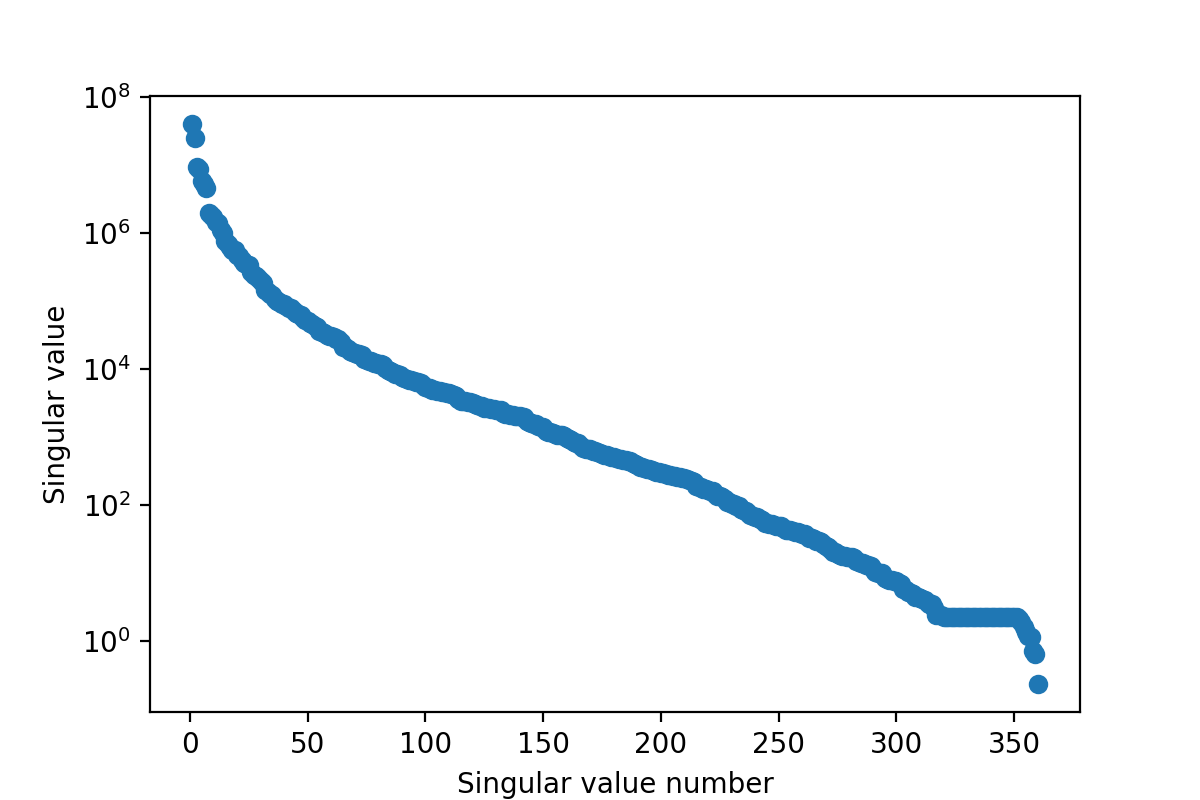

In [878]:
# plot singular values of music pieces
# each singular value represents a feature
plt.figure(101, figsize = (6,4))
#plt.subplot(121)
#plt.scatter(np.arange(1,len(s1)+1), s1)
#plt.xlabel('Singular value number')
#plt.ylabel('Singular value')
#plt.subplot(122)
plt.semilogy(np.arange(1,len(s1)+1), s1, 'o')
plt.xlabel('Singular value number')
plt.ylabel('Singular value')
plt.show()

### Clarification

u1: columns = eigenmodes

s1: std dev of features

vh1: columns = weights of features for each music piece

vh1: rows = weights of music pieces for each feature

v1: vh1.transpose

### Cross Validation

In [347]:
# import packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [559]:
def train_test_gen(data, range_feat, num_clip):
    '''
    Generate train and test set randomly
    Input:
        data: (Numpy array) data with features (each data = each row)
        range_feat: (Numpy array) range of features selected
        num_clip: (int) number of clips for each genre
    Output:
        return train and test set as numpy arrays
    '''
    
    # dimension
    shape = data.shape
    # sanity check
    if float.is_integer(shape[0]/num_clip) == False:
        print('Error: Invalid num_clip. ')
        return
    
    num_genre = int(shape[0]/num_clip)
    num_feat = len(range_feat)
    
    test_size = 0.2
    xtrain = np.zeros((num_genre, num_clip - int(num_clip*test_size), num_feat))
    xtest = np.zeros((num_genre, int(num_clip*test_size), num_feat))
    ytrain = np.zeros((num_genre, num_clip - int(num_clip*test_size)))
    ytest = np.zeros((num_genre, int(num_clip*test_size)))
    
    for i in range(num_genre):
        
        xtemp = data[i*num_clip:(i+1)*num_clip, range_feat]
        ytemp = np.ones(num_clip)*(i+1) # class
        # train test split
        xtrain[i], xtest[i], ytrain[i], ytest[i] = train_test_split(xtemp, ytemp, test_size = 0.2)
    
    xtrain = np.concatenate(xtrain)
    xtest = np.concatenate(xtest)
    ytrain = np.concatenate(ytrain)
    ytest = np.concatenate(ytest)
    
    # shuffle train set
    idx = np.arange(len(ytrain))
    np.random.shuffle(idx)
    xtrain = xtrain[idx]
    ytrain = ytrain[idx]
    
    return xtrain, xtest, ytrain, ytest

### Classification - KNN

In [522]:
# import packages
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import svm

In [595]:
# params
range_feature = np.arange(1,10)
num_clip = 120
# train test split
xtrain, xtest, ytrain, ytest = train_test_gen(vh1.transpose(), range_feature, 120)

<IPython.core.display.Javascript object>


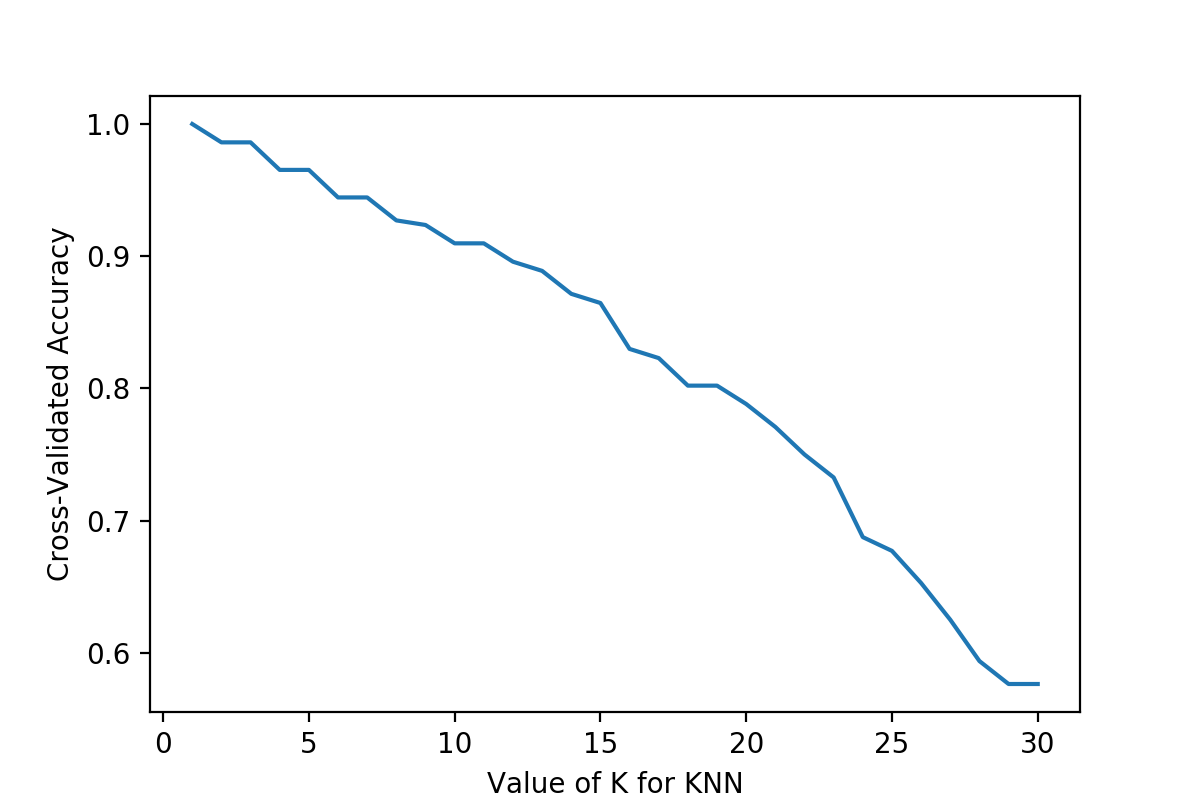

In [661]:
# choose knn parameter
k_scores = []
#k_errors = []
k_range = np.arange(1,31)
for k in k_range:
    knn = KNN(n_neighbors = k)
    scores = cross_val_score(knn, xtrain, ytrain, cv = 6, scoring='accuracy')
    k_scores.append(scores.mean())
    #errors = abs(cross_val_score(knn, xtrain, ytrain, cv = 6, scoring='neg_mean_squared_error'))
    #k_errors.append(errors.mean())
    
plt.figure(102, figsize = (6, 4))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [597]:
# knn
knn_model = KNN(n_neighbors = 2)
knn_model.fit(xtrain, ytrain)
ytest_pred = knn_model.predict(xtest)

<IPython.core.display.Javascript object>


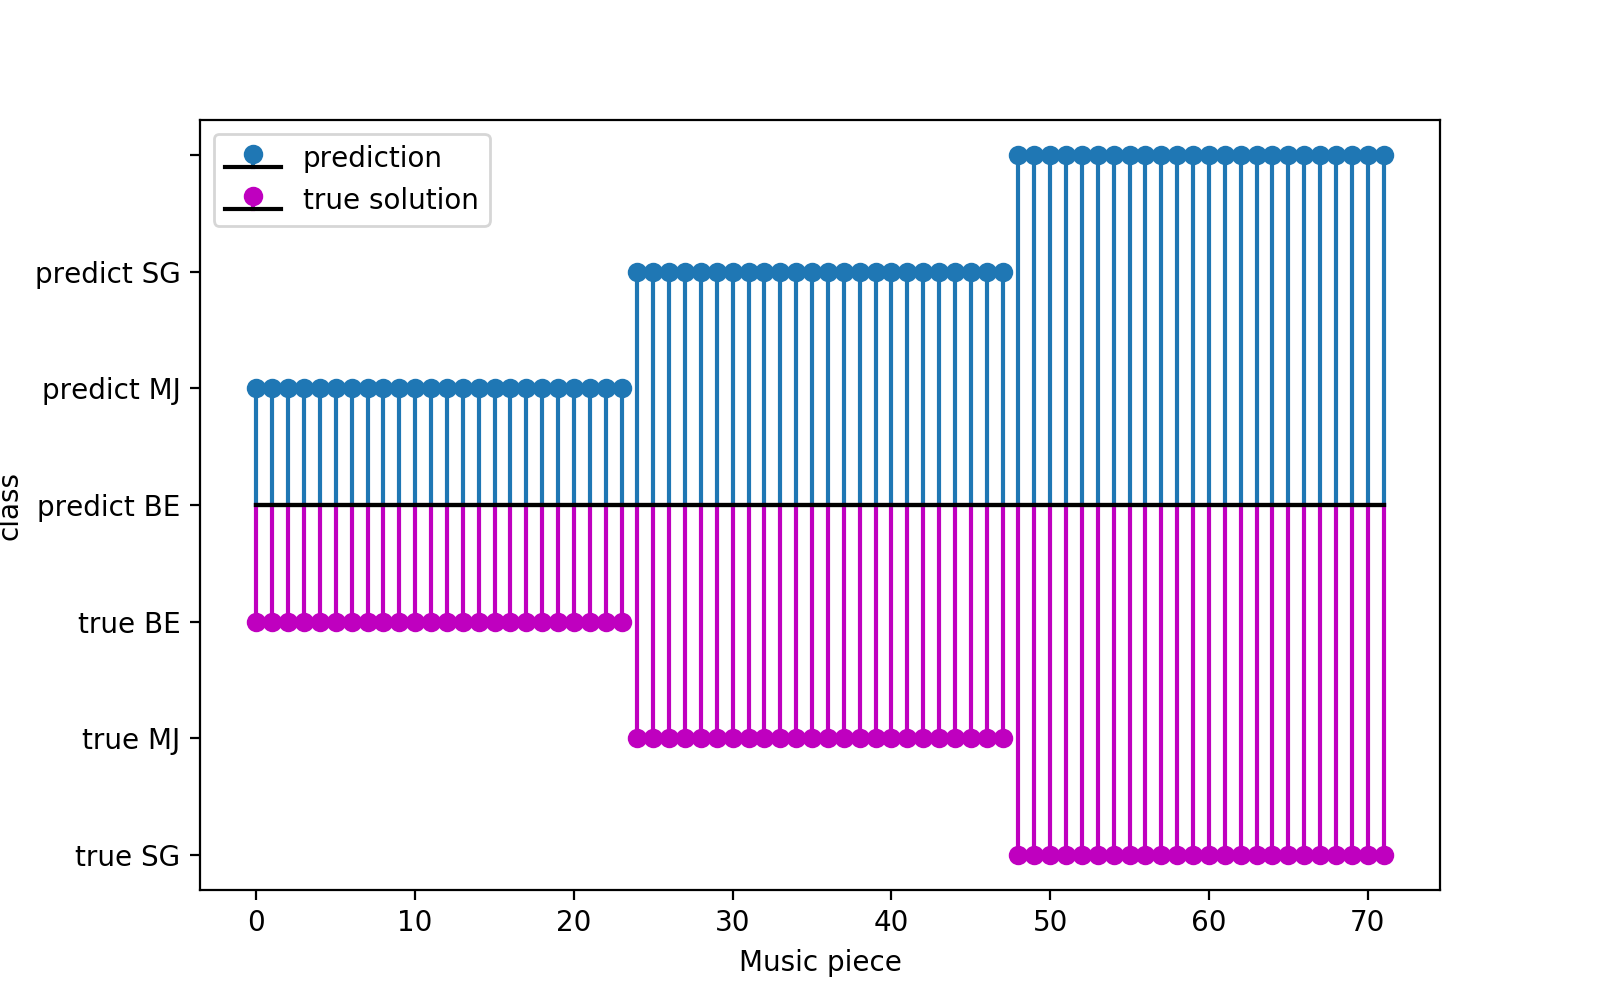

The accuracy of KNN with cross validation is 1.0. 
The accuracy of predicting test set by KNN is 1.0. 


In [598]:
test_score = knn_model.score(xtest, ytest)
cv_score = cross_val_score(knn_model, xtrain, ytrain, cv = 6, scoring='accuracy')

# plot prediction
plt.figure(103, figsize = (8, 5))
plt.stem(ytest_pred, basefmt = 'black', label = 'prediction')
plt.stem(-ytest, linefmt = 'm', markerfmt = 'mo', basefmt = 'black', label = 'true solution')
plt.xlabel('Music piece')
plt.ylabel('class')
plt.yticks(np.arange(-3, 4), ['true SG', 'true MJ', 'true BE', 'predict BE', 'predict MJ', 'predict SG'])
plt.legend()
plt.show()

print('The accuracy of KNN with cross validation is {0}. '.format(cv_score.mean()))
print('The accuracy of predicting test set by KNN is {0}. '.format(test_score))

### Classification - Naive Bayes

In [601]:
# params
range_feature = np.arange(200)
num_clip = 120
# train test split
xtrain, xtest, ytrain, ytest = train_test_gen(vh1.transpose(), range_feature, 120)

In [602]:
gnb_model = GaussianNB()
cross_val_score(gnb_model, xtrain, ytrain, cv = 6, scoring = 'accuracy')

array([1., 1., 1., 1., 1., 1.])

In [603]:
gnb_model = GaussianNB()
gnb_model.fit(xtrain, ytrain)
ytest_pred = gnb_model.predict(xtest)

<IPython.core.display.Javascript object>


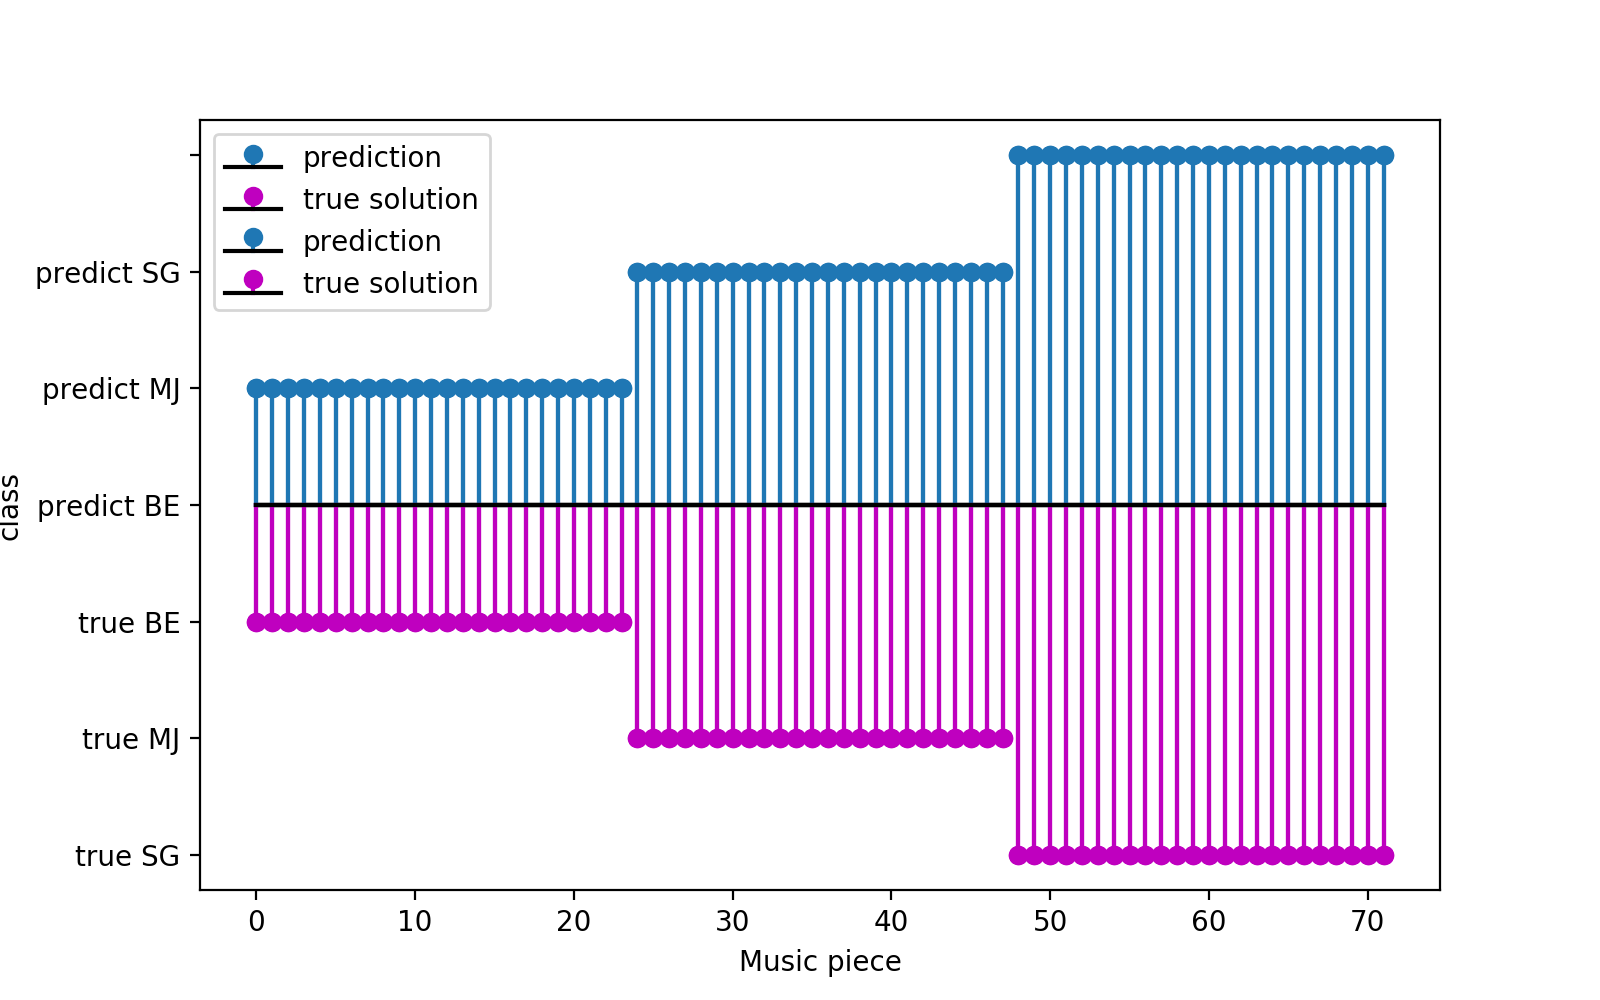

The accuracy of Naive Bayes with cross validation is 1.0. 
The accuracy of predicting test set by Naive Bayes is 1.0. 


In [604]:
test_score = gnb_model.score(xtest, ytest)
cv_score = cross_val_score(gnb_model, xtrain, ytrain, cv = 6, scoring='accuracy')

# plot prediction
plt.figure(104, figsize = (8, 5))
plt.stem(ytest_pred, basefmt = 'black', label = 'prediction')
plt.stem(-ytest, linefmt = 'm', markerfmt = 'mo', basefmt = 'black', label = 'true solution')
plt.xlabel('Music piece')
plt.ylabel('class')
plt.yticks(np.arange(-3, 4), ['true SG', 'true MJ', 'true BE', 'predict BE', 'predict MJ', 'predict SG'])
plt.legend()
plt.show()

print('The accuracy of Naive Bayes with cross validation is {0}. '.format(cv_score.mean()))
print('The accuracy of predicting test set by Naive Bayes is {0}. '.format(test_score))

### Classification - LDA

In [646]:
# params
range_feature = np.arange(50)
num_clip = 120
# train test split
xtrain, xtest, ytrain, ytest = train_test_gen(vh1.transpose(), range_feature, 120)

In [647]:
lda_model = LDA()
cross_val_score(lda_model, xtrain, ytrain, cv = 5, scoring = 'accuracy')

array([1.        , 1.        , 0.98245614, 1.        , 1.        ])

In [648]:
lda_model = LDA()
lda_model.fit(xtrain, ytrain)
ytest_pred = lda_model.predict(xtest)

<IPython.core.display.Javascript object>


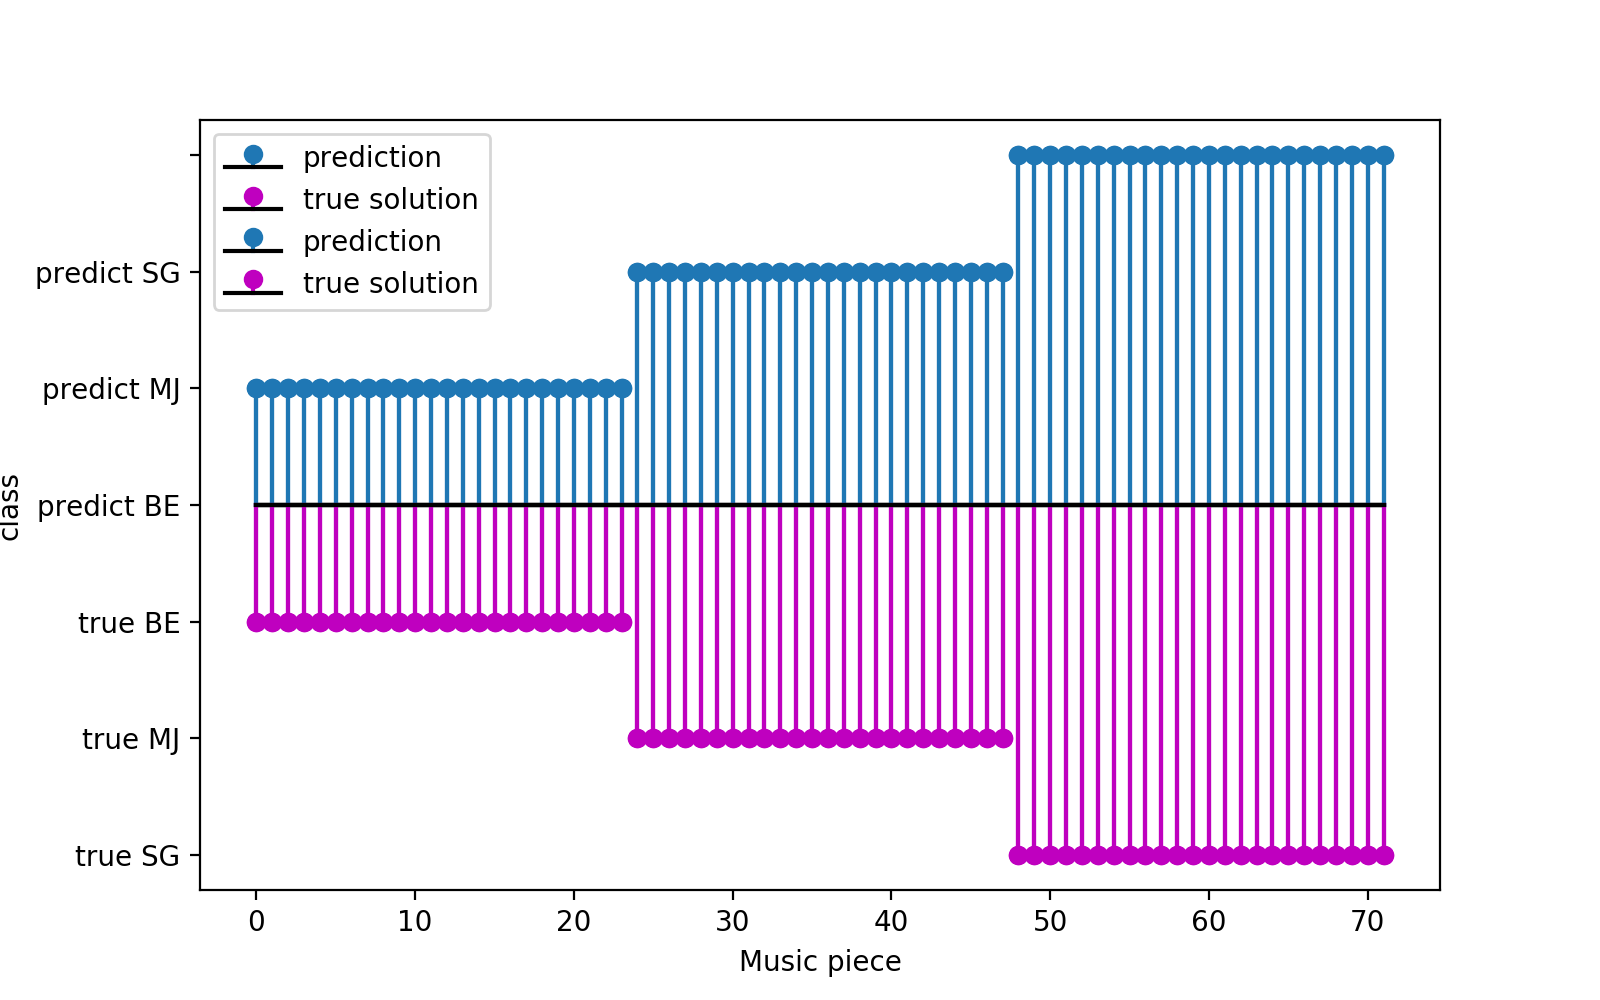

The accuracy of LDA with cross validation is 1.0. 
The accuracy of predicting test set by LDA is 1.0. 


In [649]:
test_score = lda_model.score(xtest, ytest)
cv_score = cross_val_score(lda_model, xtrain, ytrain, cv = 6, scoring='accuracy')

# plot prediction
plt.figure(105, figsize = (8, 5))
plt.stem(ytest_pred, basefmt = 'black', label = 'prediction')
plt.stem(-ytest, linefmt = 'm', markerfmt = 'mo', basefmt = 'black', label = 'true solution')
plt.xlabel('Music piece')
plt.ylabel('class')
plt.yticks(np.arange(-3, 4), ['true SG', 'true MJ', 'true BE', 'predict BE', 'predict MJ', 'predict SG'])
plt.legend()
plt.show()

print('The accuracy of LDA with cross validation is {0}. '.format(cv_score.mean()))
print('The accuracy of predicting test set by LDA is {0}. '.format(test_score))

### Classification - SVM

<IPython.core.display.Javascript object>


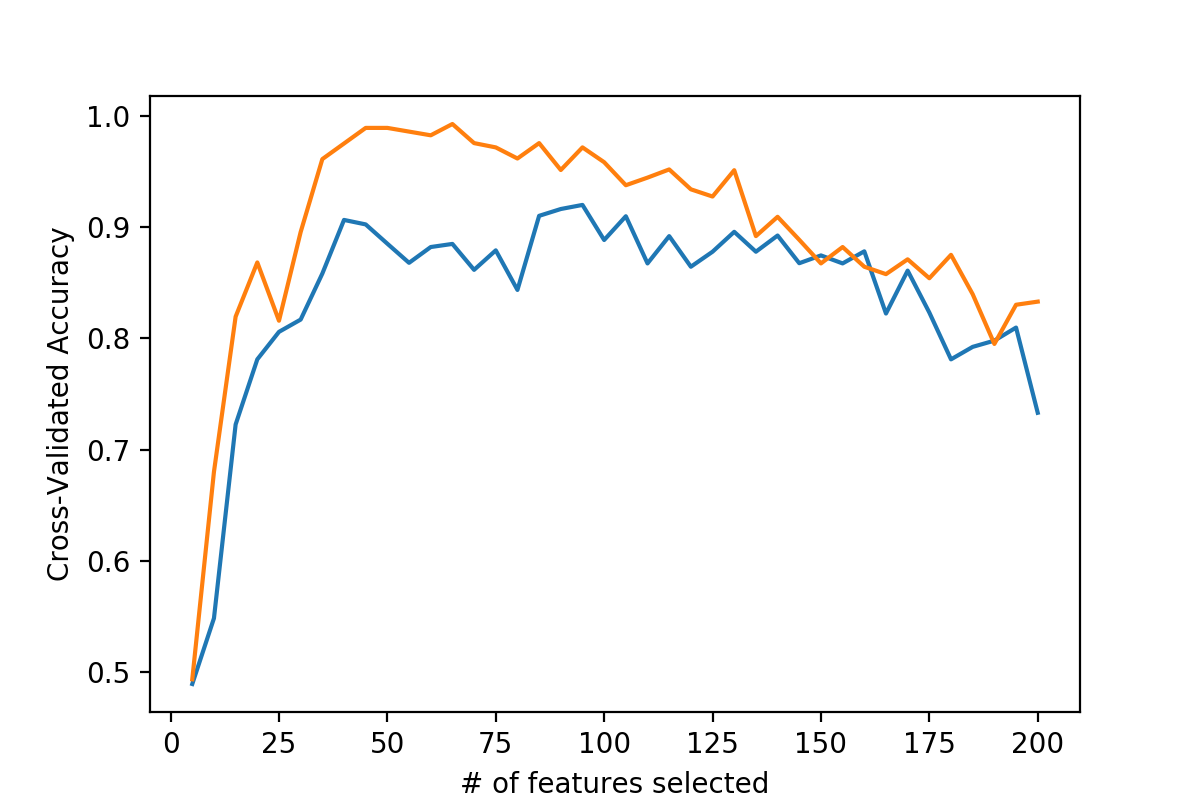

In [670]:
# determine num of features selected
num_list = np.arange(5, 205, 5)
cv_scores = []
for num in num_list:
    range_feature = np.arange(num)
    num_clip = 120
    # train test split
    xtrain, xtest, ytrain, ytest = train_test_gen(vh1.transpose(), range_feature, 120)
    svm_model = svm.SVC(gamma = 'auto')
    score = cross_val_score(svm_model, xtrain, ytrain, cv = 5, scoring = 'accuracy')
    cv_scores.append(score.mean())
    
# plot
plt.figure(116, figsize = (6, 4))
plt.plot(num_list, cv_scores)
plt.xlabel('# of features selected')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [641]:
# params
range_feature = np.arange(90)
num_clip = 120
# train test split
xtrain, xtest, ytrain, ytest = train_test_gen(vh1.transpose(), range_feature, 120)

In [642]:
svm_model = svm.SVC(gamma = 'auto')
cross_val_score(svm_model, xtrain, ytrain, cv = 6, scoring = 'accuracy')

array([0.9375    , 0.97916667, 0.91666667, 0.875     , 0.97916667,
       0.875     ])

In [643]:
svm_model = svm.SVC(gamma = 'auto')
svm_model.fit(xtrain, ytrain)
ytest_pred = svm_model.predict(xtest)

<IPython.core.display.Javascript object>


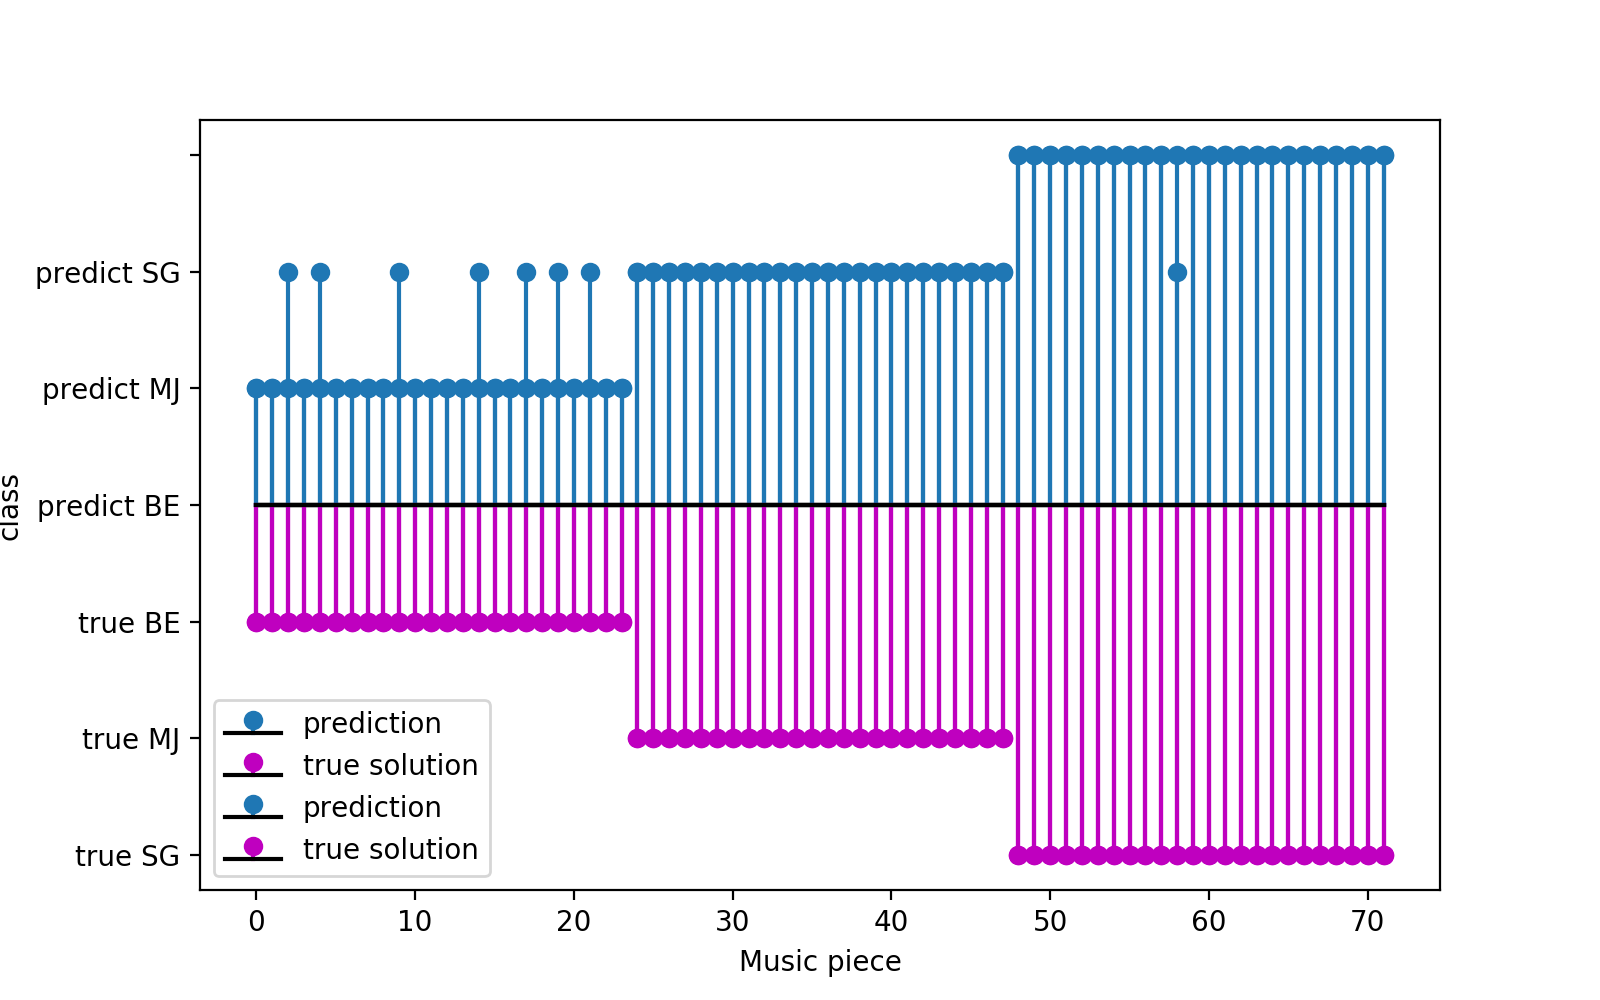

The accuracy of LDA with cross validation is 0.9270833333333334. 
The accuracy of predicting test set by LDA is 0.8888888888888888. 


In [645]:
test_score = svm_model.score(xtest, ytest)
cv_score = cross_val_score(svm_model, xtrain, ytrain, cv = 6, scoring='accuracy')

# plot prediction
plt.figure(106, figsize = (8, 5))
plt.stem(ytest_pred, basefmt = 'black', label = 'prediction')
plt.stem(-ytest, linefmt = 'm', markerfmt = 'mo', basefmt = 'black', label = 'true solution')
plt.xlabel('Music piece')
plt.ylabel('class')
plt.yticks(np.arange(-3, 4), ['true SG', 'true MJ', 'true BE', 'predict BE', 'predict MJ', 'predict SG'])
plt.legend()
plt.show()

print('The accuracy of LDA with cross validation is {0}. '.format(cv_score.mean()))
print('The accuracy of predicting test set by LDA is {0}. '.format(test_score))

## Test 2

### Initialization

In [650]:
# initialize data
pj = genre_init('dataset/Pearl_Jam', fname_spec = '.mp3', fs_default = 44100)
# calculate spectrogram
pj_spec = genre_spec(pj)

In [651]:
# initialize data
aic = genre_init('dataset/Alice_in_chains', fname_spec = '.mp3', fs_default = 44100)
# calculate spectrogram
aic_spec = genre_spec(aic)

In [652]:
# concatenate into a big matrix
test2 = np.concatenate((soundgard_spec, aic_spec, pj_spec), axis = 1)
# subtract mean
test2 = test2 - test2.mean(axis = 0)

### SVD

In [653]:
%%time
u2f, s2f, vh2f = jsp.linalg.svd(test2, full_matrices = False)

CPU times: user 79 ms, sys: 72.7 ms, total: 152 ms
Wall time: 192 ms


In [654]:
%%time
u2 = np.asarray(u2f)
s2 = np.asarray(s2f)
vh2 = np.asarray(vh2f)

CPU times: user 1.01 ms, sys: 15 ms, total: 16 ms
Wall time: 17.2 ms


<IPython.core.display.Javascript object>


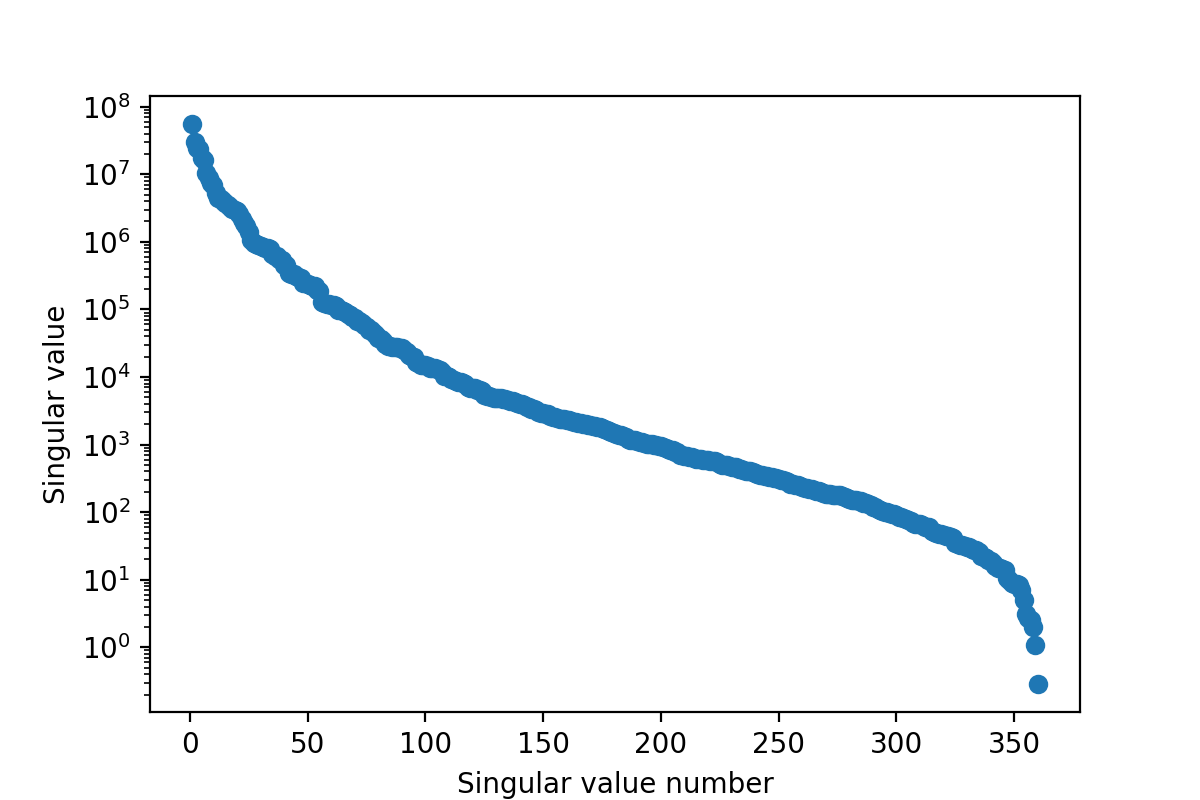

In [879]:
# plot singular values of music pieces
# each singular value represents a feature
plt.figure(121, figsize = (6,4))
#plt.subplot(121)
#plt.scatter(np.arange(1,len(s2)+1), s2)
#plt.xlabel('Singular value number')
#plt.ylabel('Singular value')
#plt.subplot(122)
plt.semilogy(np.arange(1,len(s2)+1), s2, 'o')
plt.xlabel('Singular value number')
plt.ylabel('Singular value')
plt.show()

### Classification - KNN

<IPython.core.display.Javascript object>


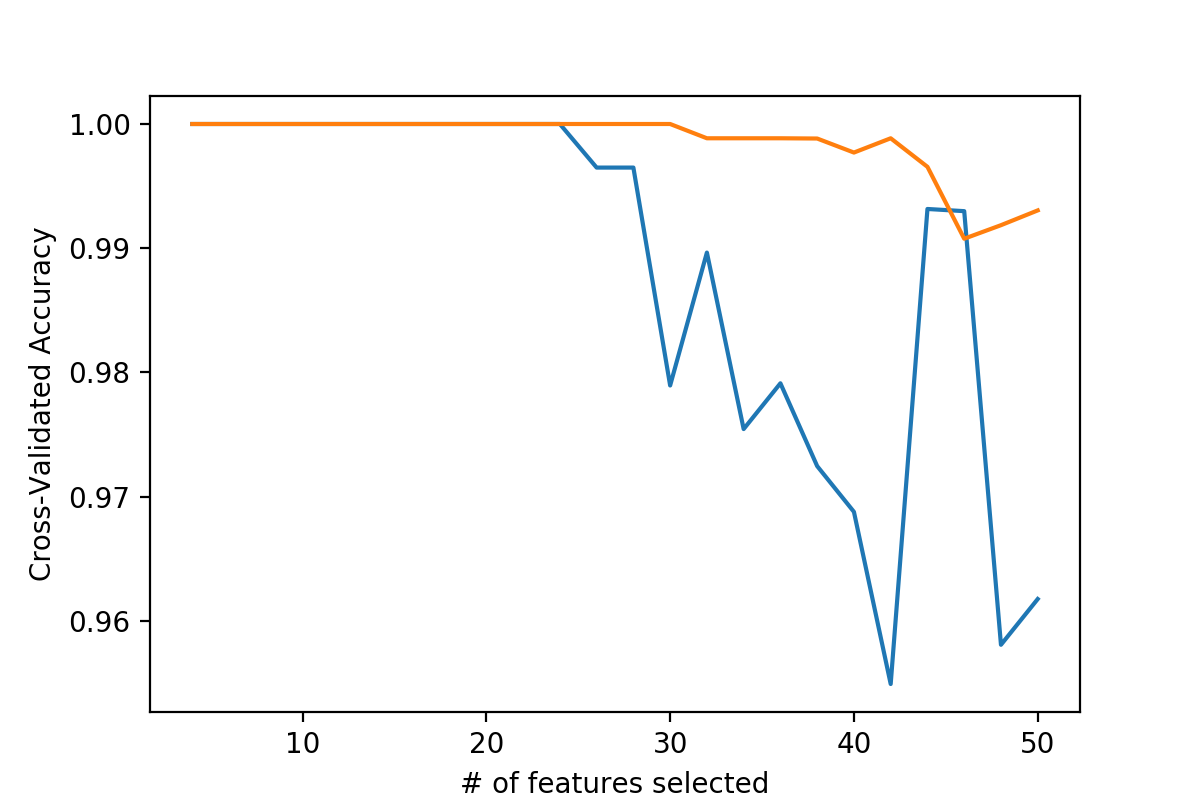

In [686]:
# determine num of features selected
num_list = np.arange(4, 52, 2)
cv_scores = []
for num in num_list:
    range_feature = np.arange(num)
    num_clip = 120
    # train test split
    xtrain, xtest, ytrain, ytest = train_test_gen(vh2.transpose(), range_feature, 120)
    knn_model = KNN(n_neighbors = 5)
    score = cross_val_score(knn_model, xtrain, ytrain, cv = 5, scoring = 'accuracy')
    cv_scores.append(score.mean())
    
# plot
plt.figure(126, figsize = (6, 4))
plt.plot(num_list, cv_scores)
plt.xlabel('# of features selected')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

<IPython.core.display.Javascript object>


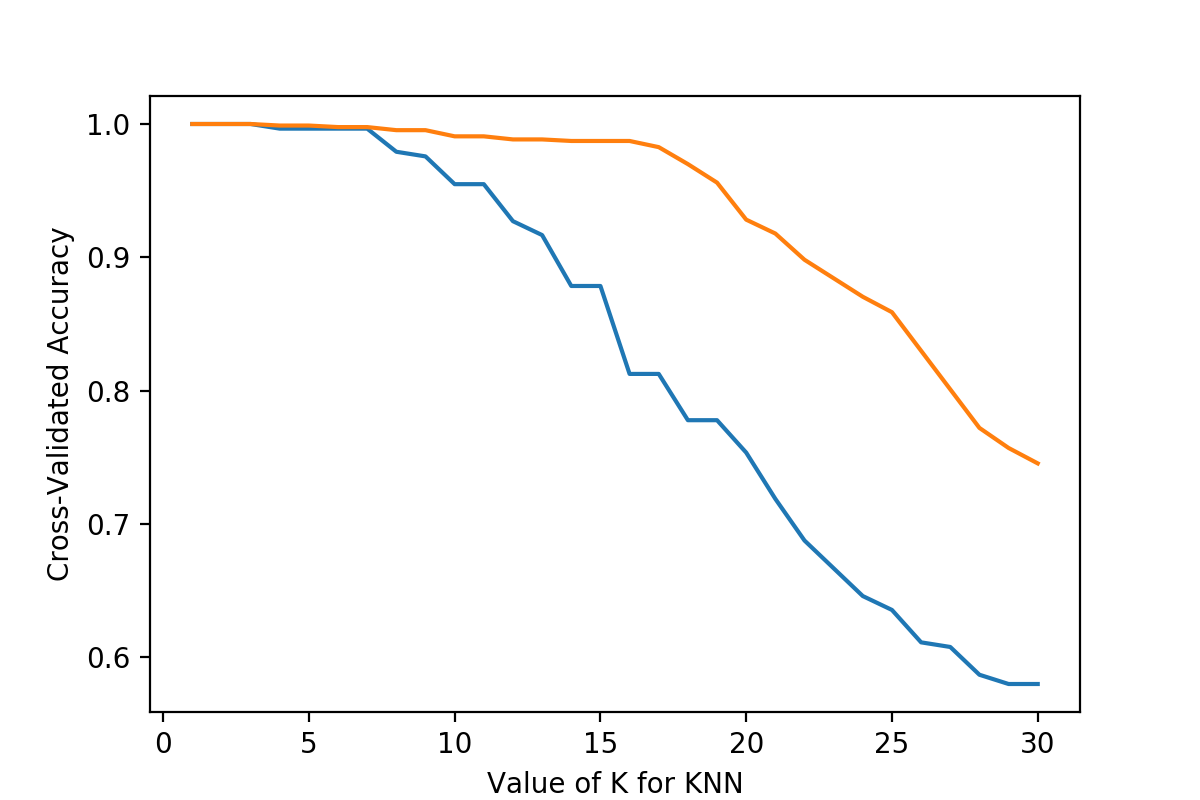

In [677]:
# choose knn parameter
k_scores = []
#k_errors = []
k_range = np.arange(1,31)
for k in k_range:
    knn = KNN(n_neighbors = k)
    scores = cross_val_score(knn, xtrain, ytrain, cv = 6, scoring='accuracy')
    k_scores.append(scores.mean())
    #errors = abs(cross_val_score(knn, xtrain, ytrain, cv = 6, scoring='neg_mean_squared_error'))
    #k_errors.append(errors.mean())
    
plt.figure(122, figsize = (6, 4))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [738]:
# params
range_feature = np.arange(1,20)
num_clip = 120
# train test split
xtrain, xtest, ytrain, ytest = train_test_gen(vh2.transpose(), range_feature, 120)

In [739]:
# knn
knn_model = KNN(n_neighbors = 5)
knn_model.fit(xtrain, ytrain)
ytest_pred = knn_model.predict(xtest)

<IPython.core.display.Javascript object>


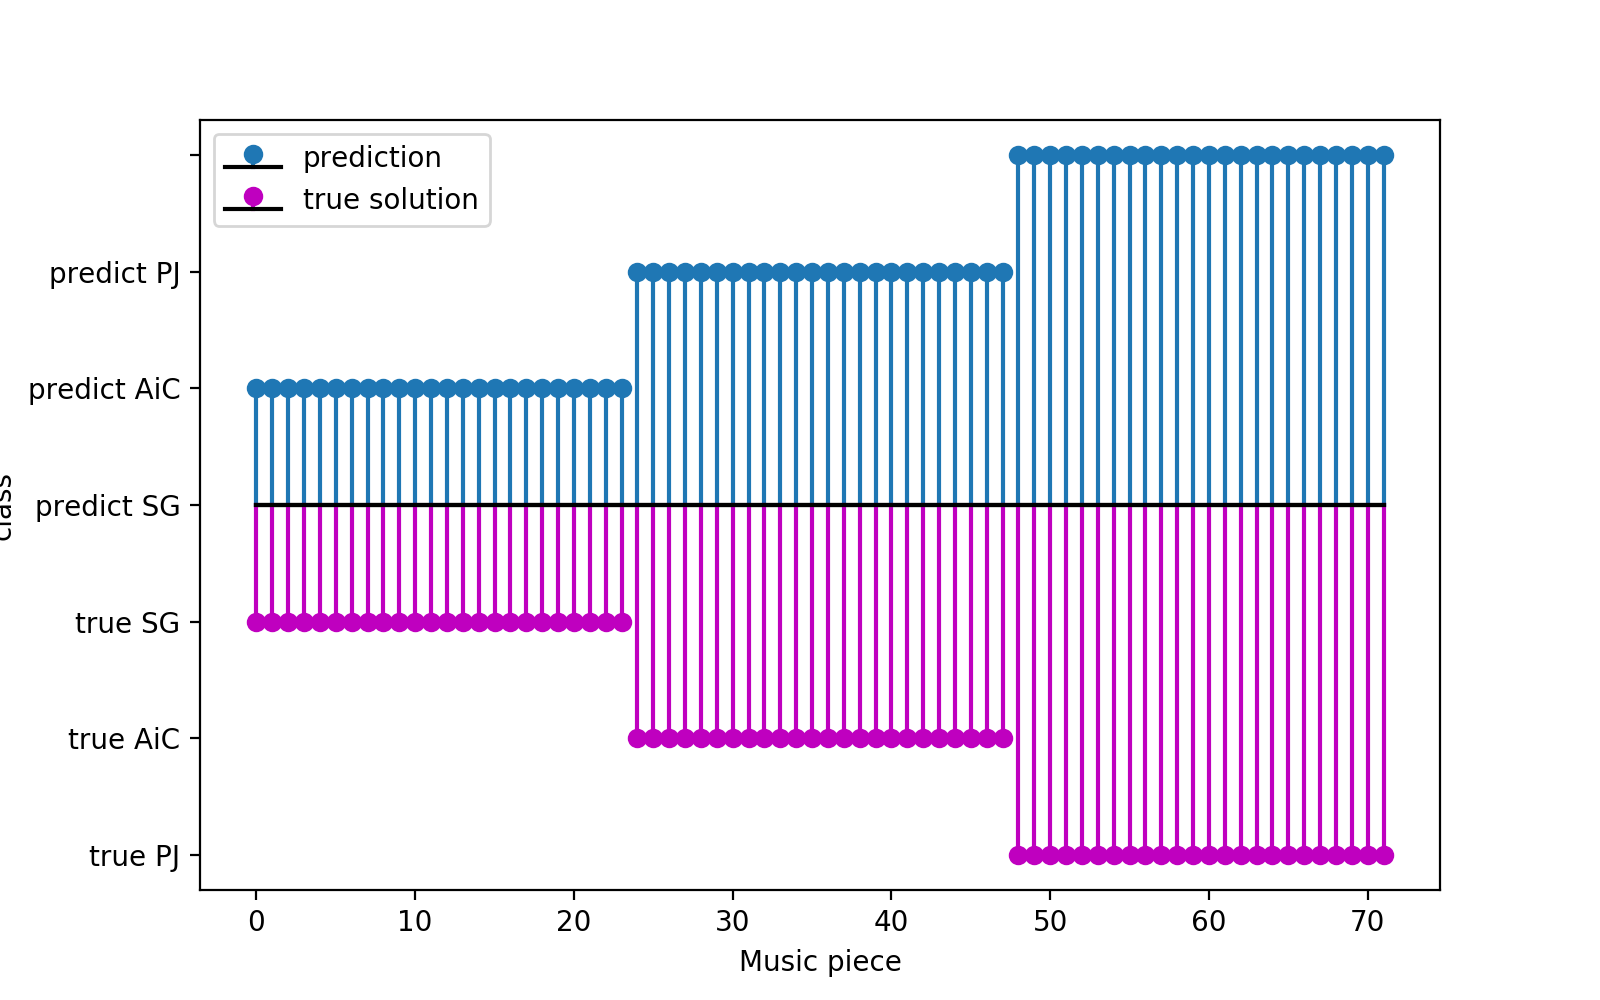

The accuracy of KNN with cross validation is 1.0. 
The accuracy of predicting test set by KNN is 1.0. 


In [740]:
test_score = knn_model.score(xtest, ytest)
cv_score = cross_val_score(knn_model, xtrain, ytrain, cv = 6, scoring='accuracy')

# plot prediction
plt.figure(123, figsize = (8, 5))
plt.stem(ytest_pred, basefmt = 'black', label = 'prediction')
plt.stem(-ytest, linefmt = 'm', markerfmt = 'mo', basefmt = 'black', label = 'true solution')
plt.xlabel('Music piece')
plt.ylabel('class')
plt.yticks(np.arange(-3, 4), ['true PJ', 'true AiC', 'true SG', 'predict SG', 'predict AiC', 'predict PJ'])
plt.legend()
plt.show()

print('The accuracy of KNN with cross validation is {0}. '.format(cv_score.mean()))
print('The accuracy of predicting test set by KNN is {0}. '.format(test_score))

### Classification - Naive Bayes

<IPython.core.display.Javascript object>


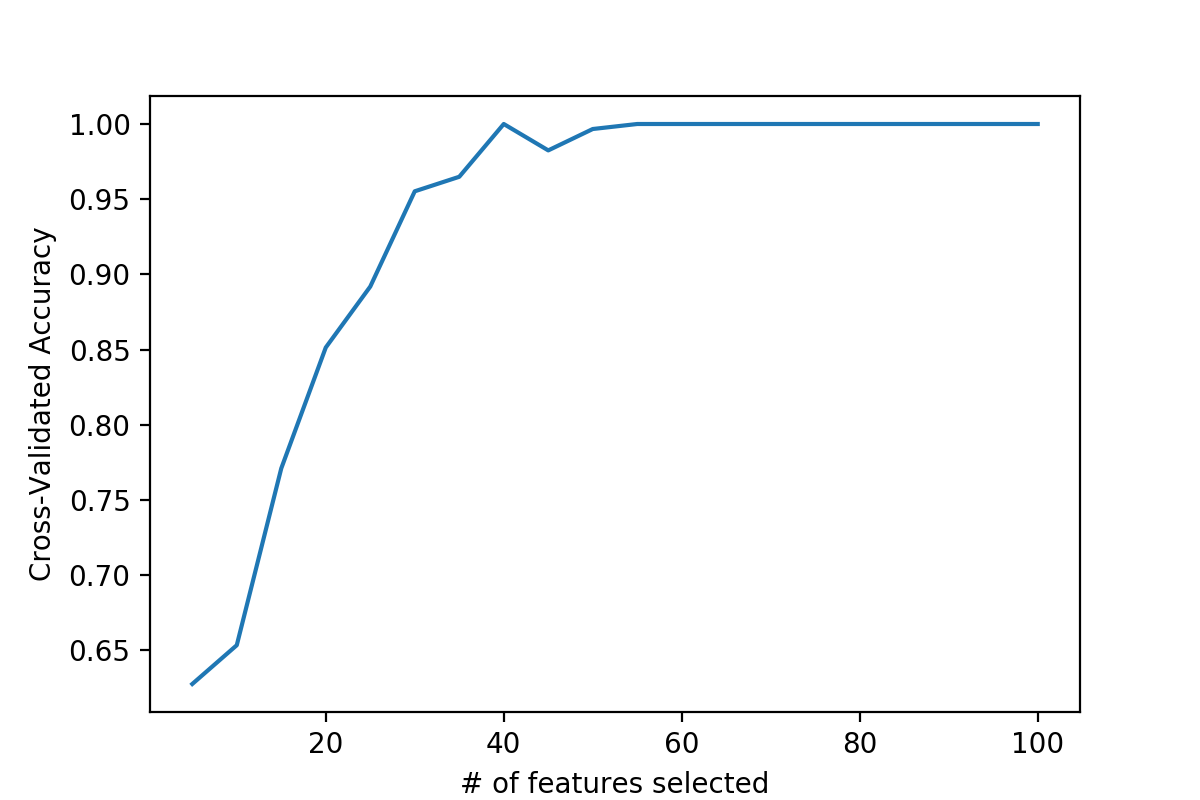

In [688]:
# determine num of features selected
num_list = np.arange(5, 105, 5)
cv_scores = []
for num in num_list:
    range_feature = np.arange(num)
    num_clip = 120
    # train test split
    xtrain, xtest, ytrain, ytest = train_test_gen(vh2.transpose(), range_feature, 120)
    gnb_model = GaussianNB()
    score = cross_val_score(gnb_model, xtrain, ytrain, cv = 5, scoring = 'accuracy')
    cv_scores.append(score.mean())
    
# plot
plt.figure(131, figsize = (6, 4))
plt.plot(num_list, cv_scores)
plt.xlabel('# of features selected')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [741]:
# params
range_feature = np.arange(80)
num_clip = 120
# train test split
xtrain, xtest, ytrain, ytest = train_test_gen(vh2.transpose(), range_feature, 120)

In [742]:
gnb_model = GaussianNB()
cross_val_score(gnb_model, xtrain, ytrain, cv = 6, scoring = 'accuracy')

array([1., 1., 1., 1., 1., 1.])

In [743]:
gnb_model = GaussianNB()
gnb_model.fit(xtrain, ytrain)
ytest_pred = gnb_model.predict(xtest)

<IPython.core.display.Javascript object>


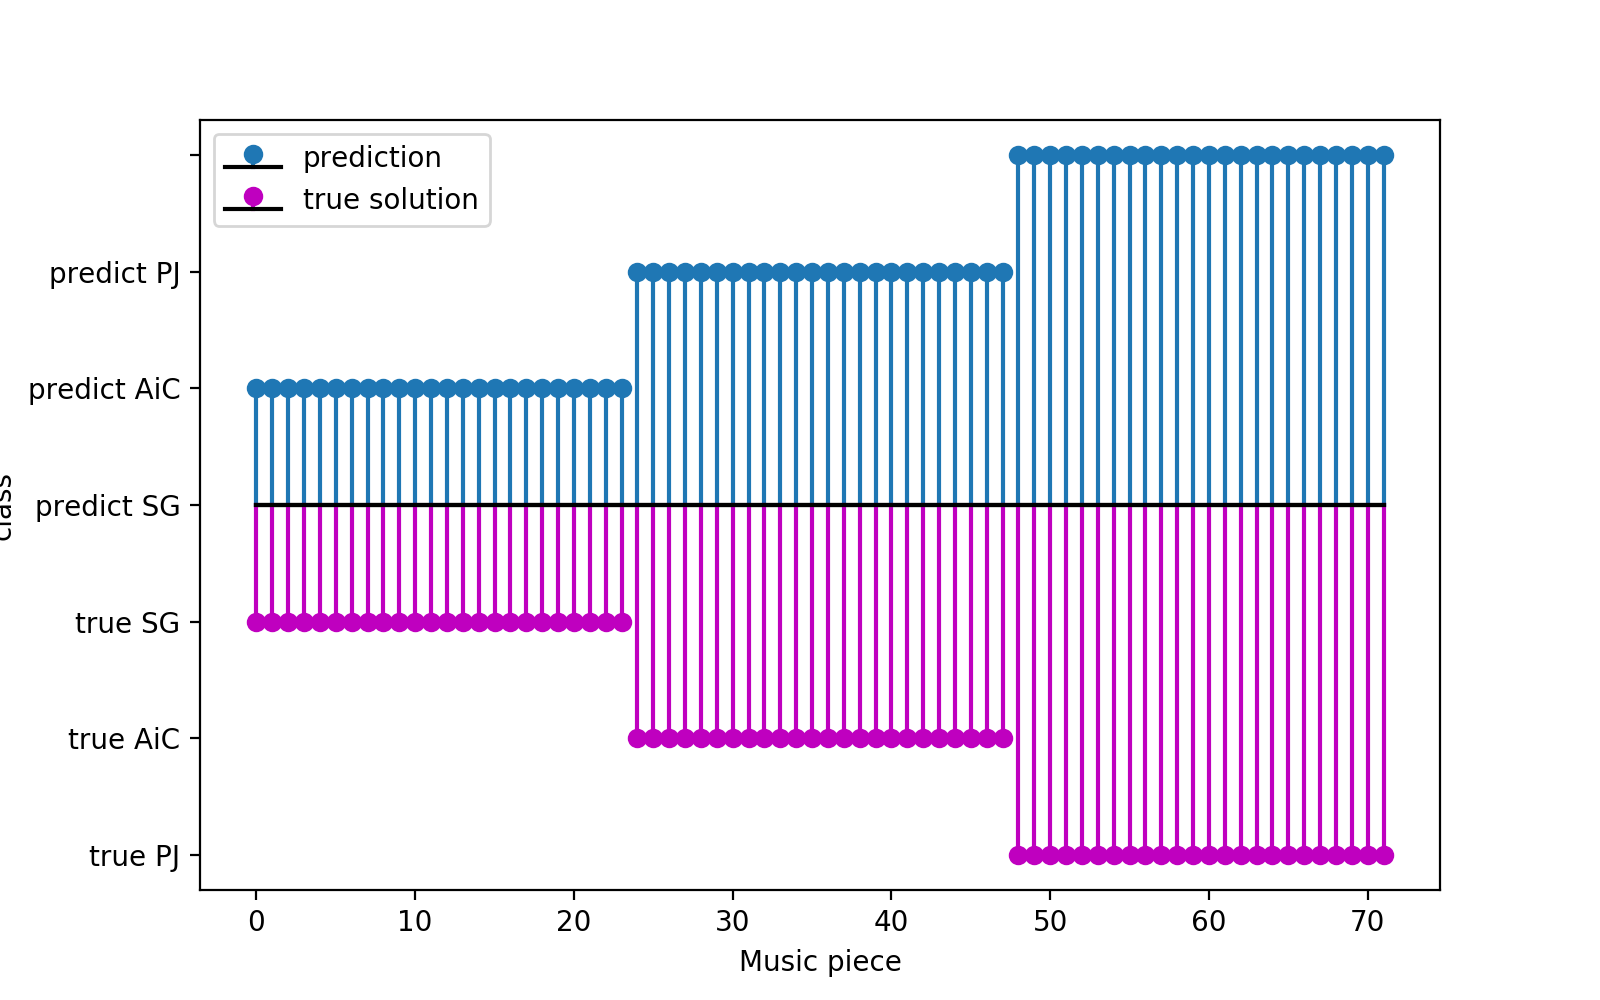

The accuracy of Naive Bayes with cross validation is 1.0. 
The accuracy of predicting test set by Naive Bayes is 1.0. 


In [744]:
test_score = gnb_model.score(xtest, ytest)
cv_score = cross_val_score(gnb_model, xtrain, ytrain, cv = 6, scoring='accuracy')

# plot prediction
plt.figure(134, figsize = (8, 5))
plt.stem(ytest_pred, basefmt = 'black', label = 'prediction')
plt.stem(-ytest, linefmt = 'm', markerfmt = 'mo', basefmt = 'black', label = 'true solution')
plt.xlabel('Music piece')
plt.ylabel('class')
plt.yticks(np.arange(-3, 4), ['true PJ', 'true AiC', 'true SG', 'predict SG', 'predict AiC', 'predict PJ'])
plt.legend()
plt.show()

print('The accuracy of Naive Bayes with cross validation is {0}. '.format(cv_score.mean()))
print('The accuracy of predicting test set by Naive Bayes is {0}. '.format(test_score))

### Classification - LDA

<IPython.core.display.Javascript object>


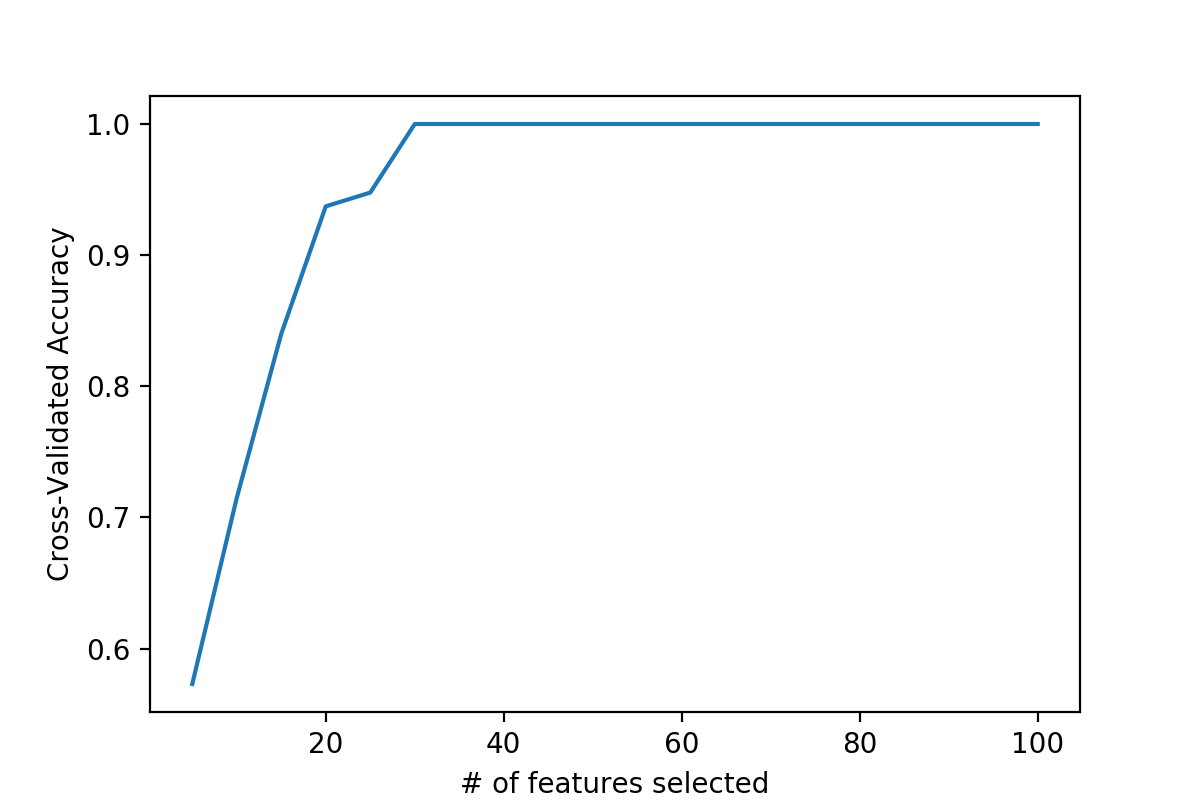

In [694]:
# determine num of features selected
num_list = np.arange(5, 105, 5)
cv_scores = []
for num in num_list:
    range_feature = np.arange(num)
    num_clip = 120
    # train test split
    xtrain, xtest, ytrain, ytest = train_test_gen(vh2.transpose(), range_feature, 120)
    lda_model = LDA()
    score = cross_val_score(lda_model, xtrain, ytrain, cv = 5, scoring = 'accuracy')
    cv_scores.append(score.mean())
    
# plot
plt.figure(141, figsize = (6, 4))
plt.plot(num_list, cv_scores)
plt.xlabel('# of features selected')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [745]:
# params
range_feature = np.arange(40)
num_clip = 120
# train test split
xtrain, xtest, ytrain, ytest = train_test_gen(vh2.transpose(), range_feature, 120)

In [746]:
lda_model = LDA()
cross_val_score(lda_model, xtrain, ytrain, cv = 6, scoring = 'accuracy')

array([1., 1., 1., 1., 1., 1.])

In [747]:
lda_model = LDA()
lda_model.fit(xtrain, ytrain)
ytest_pred = lda_model.predict(xtest)

<IPython.core.display.Javascript object>


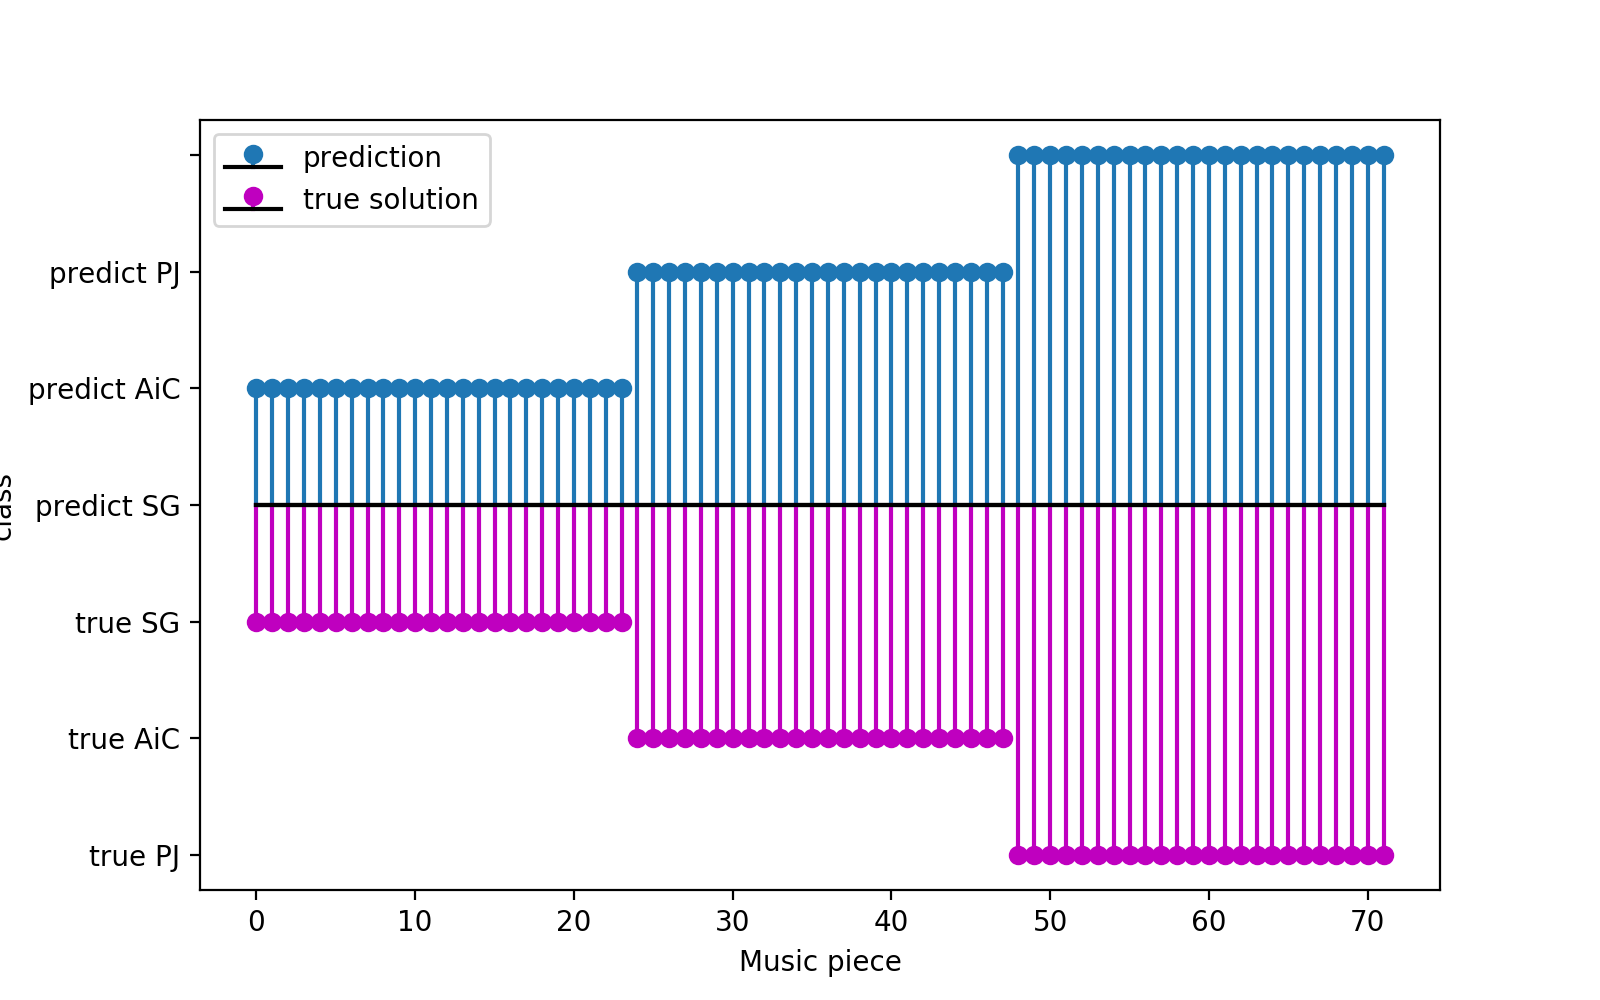

The accuracy of LDA with cross validation is 1.0. 
The accuracy of predicting test set by LDA is 1.0. 


In [748]:
test_score = lda_model.score(xtest, ytest)
cv_score = cross_val_score(lda_model, xtrain, ytrain, cv = 6, scoring='accuracy')

# plot prediction
plt.figure(145, figsize = (8, 5))
plt.stem(ytest_pred, basefmt = 'black', label = 'prediction')
plt.stem(-ytest, linefmt = 'm', markerfmt = 'mo', basefmt = 'black', label = 'true solution')
plt.xlabel('Music piece')
plt.ylabel('class')
plt.yticks(np.arange(-3, 4), ['true PJ', 'true AiC', 'true SG', 'predict SG', 'predict AiC', 'predict PJ'])
plt.legend()
plt.show()

print('The accuracy of LDA with cross validation is {0}. '.format(cv_score.mean()))
print('The accuracy of predicting test set by LDA is {0}. '.format(test_score))

### Classification - SVM

<IPython.core.display.Javascript object>


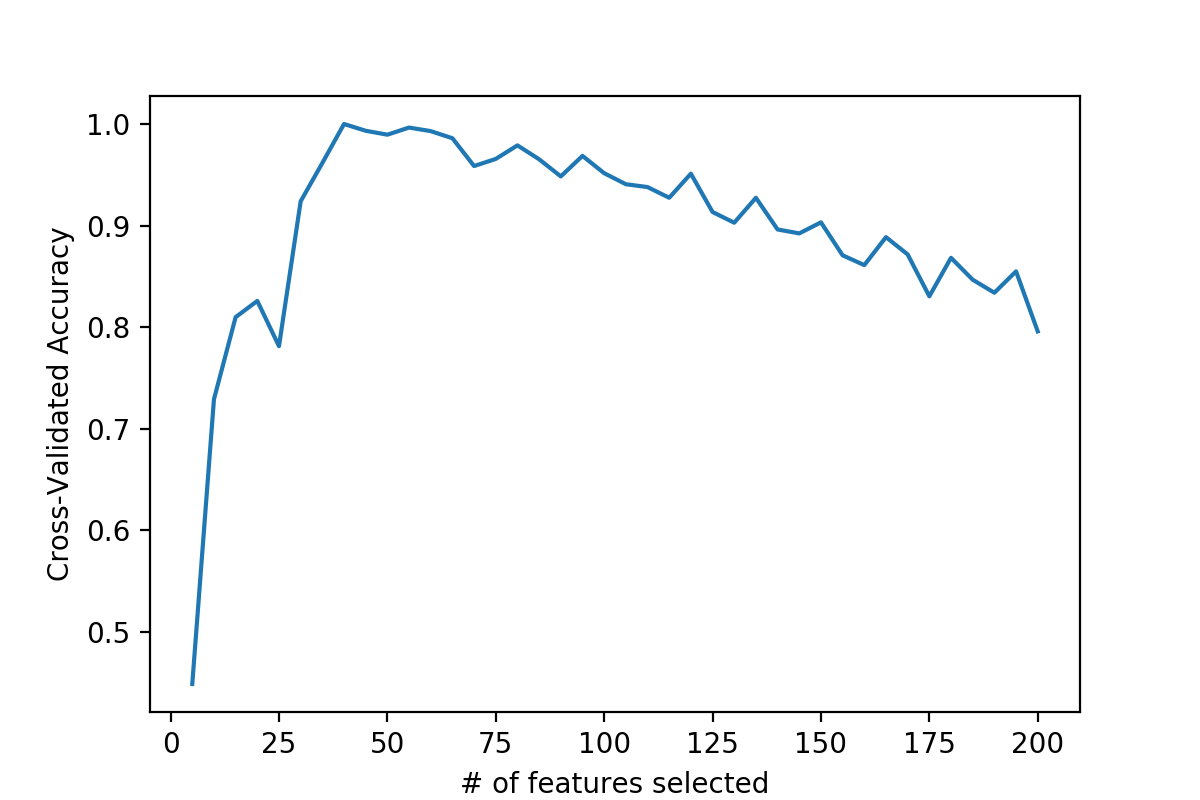

In [717]:
# determine num of features selected
num_list = np.arange(5, 205, 5)
cv_scores = []
for num in num_list:
    range_feature = np.arange(num)
    num_clip = 120
    # train test split
    xtrain, xtest, ytrain, ytest = train_test_gen(vh2.transpose(), range_feature, 120)
    svm_model = svm.SVC(gamma = 'auto')
    score = cross_val_score(svm_model, xtrain, ytrain, cv = 5, scoring = 'accuracy')
    cv_scores.append(score.mean())
    
# plot
plt.figure(156, figsize = (6, 4))
plt.plot(num_list, cv_scores)
plt.xlabel('# of features selected')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [749]:
# params
range_feature = np.arange(40)
num_clip = 120
# train test split
xtrain, xtest, ytrain, ytest = train_test_gen(vh2.transpose(), range_feature, 120)

In [750]:
svm_model = svm.SVC(gamma = 'auto')
cross_val_score(svm_model, xtrain, ytrain, cv = 6, scoring = 'accuracy')

array([1., 1., 1., 1., 1., 1.])

In [751]:
svm_model = svm.SVC(gamma = 'auto')
svm_model.fit(xtrain, ytrain)
ytest_pred = svm_model.predict(xtest)

<IPython.core.display.Javascript object>


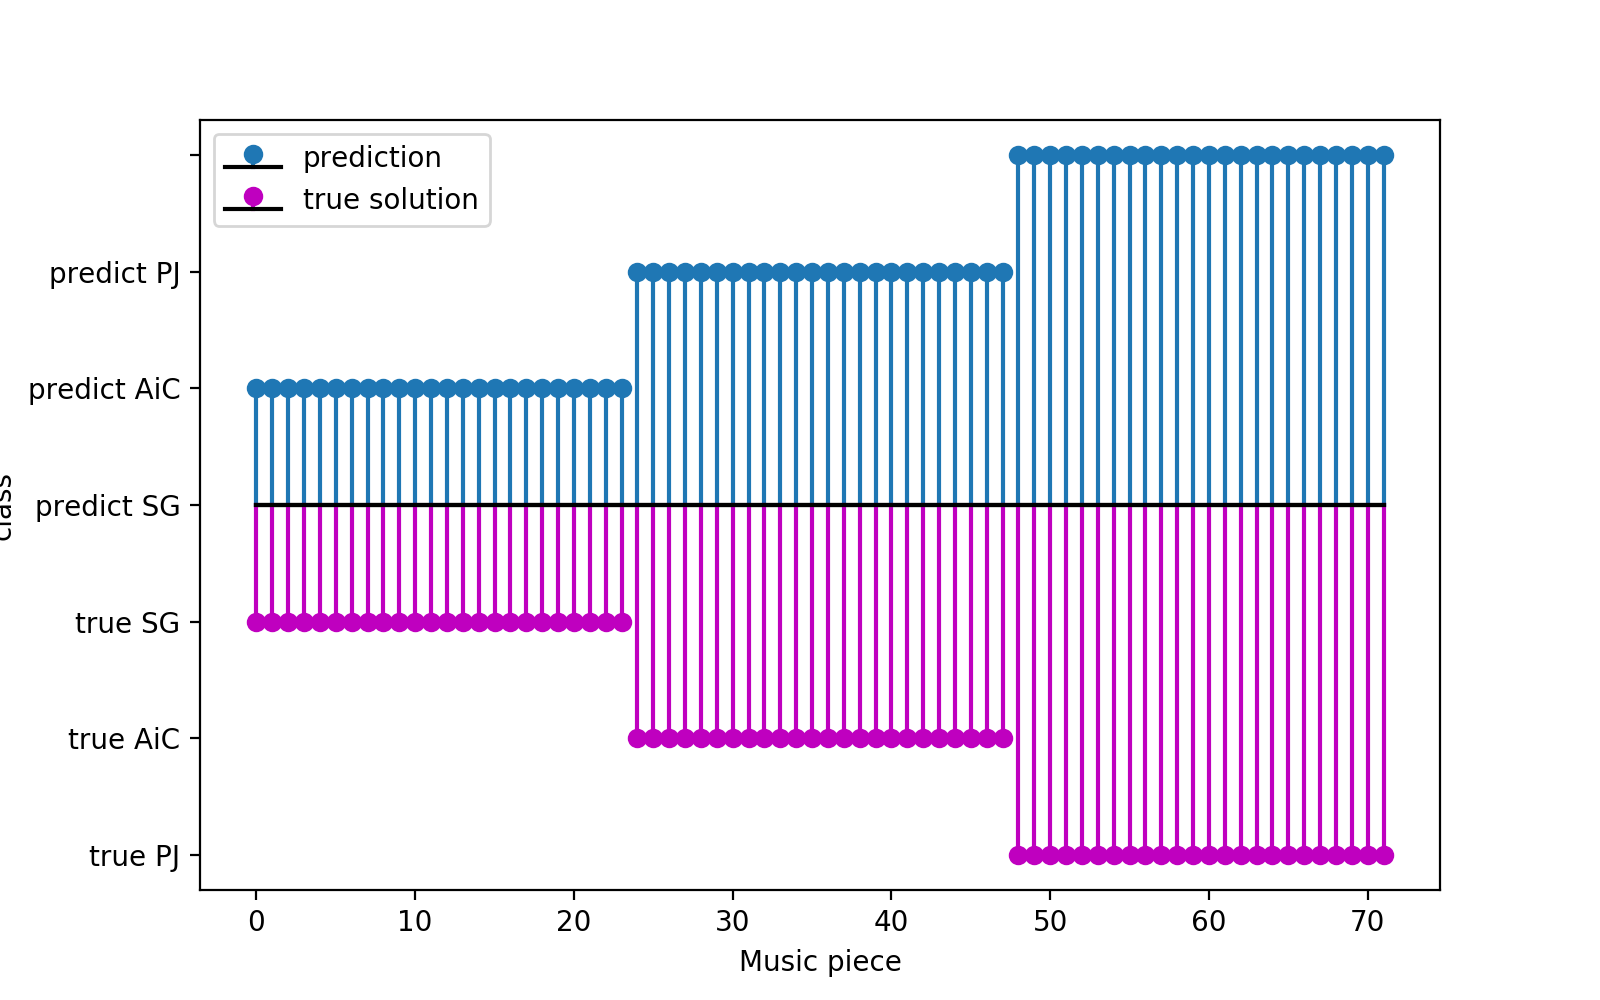

The accuracy of LDA with cross validation is 1.0. 
The accuracy of predicting test set by LDA is 1.0. 


In [752]:
test_score = svm_model.score(xtest, ytest)
cv_score = cross_val_score(svm_model, xtrain, ytrain, cv = 6, scoring='accuracy')

# plot prediction
plt.figure(166, figsize = (8, 5))
plt.stem(ytest_pred, basefmt = 'black', label = 'prediction')
plt.stem(-ytest, linefmt = 'm', markerfmt = 'mo', basefmt = 'black', label = 'true solution')
plt.xlabel('Music piece')
plt.ylabel('class')
plt.yticks(np.arange(-3, 4), ['true PJ', 'true AiC', 'true SG', 'predict SG', 'predict AiC', 'predict PJ'])
plt.legend()
plt.show()

print('The accuracy of LDA with cross validation is {0}. '.format(cv_score.mean()))
print('The accuracy of predicting test set by LDA is {0}. '.format(test_score))

## Test 3

### Initialization

In [729]:
# initialize data
beatles = genre_init('dataset/The_Beatles', fname_spec = '.mp3', fs_default = 44100)
# calculate spectrogram
bea_spec = genre_spec(beatles)

In [730]:
# initialize data
guns = genre_init('dataset/Guns_N\'_Roses', fname_spec = '.mp3', fs_default = 44100)
# calculate spectrogram
guns_spec = genre_spec(guns)

In [731]:
# initialize data
oasis = genre_init('dataset/Oasis', fname_spec = '.mp3', fs_default = 44100)
# calculate spectrogram
oasis_spec = genre_spec(oasis)

In [732]:
# initialize data
tchai = genre_init('dataset/Tchaikovsky', fname_spec = '.mp3', fs_default = 44100)
# calculate spectrogram
tchai_spec = genre_spec(tchai)

In [733]:
# initialize data
moz = genre_init('dataset/Mozart', fname_spec = '.mp3', fs_default = 44100)
# calculate spectrogram
moz_spec = genre_spec(moz)

In [734]:
# initialize data
jazz = genre_init('dataset/Jazz', fname_spec = '.mp3', fs_default = 44100)
# calculate spectrogram
jazz_spec = genre_spec(jazz)

In [753]:
# concatenate into a big matrix
test3 = np.concatenate((bea_spec, guns_spec, oasis_spec, beethoven_spec, tchai_spec, moz_spec, jazz_spec), axis = 1)
# subtract mean
test3 = test3 - test3.mean(axis = 0)

### SVD

In [755]:
%%time
u3f, s3f, vh3f = jsp.linalg.svd(test3, full_matrices = False)

CPU times: user 457 ms, sys: 2.4 s, total: 2.85 s
Wall time: 5.55 s


In [756]:
%%time
u3 = np.asarray(u3f)
s3 = np.asarray(s3f)
vh3 = np.asarray(vh3f)

CPU times: user 8.73 s, sys: 479 ms, total: 9.21 s
Wall time: 5.46 s


<IPython.core.display.Javascript object>


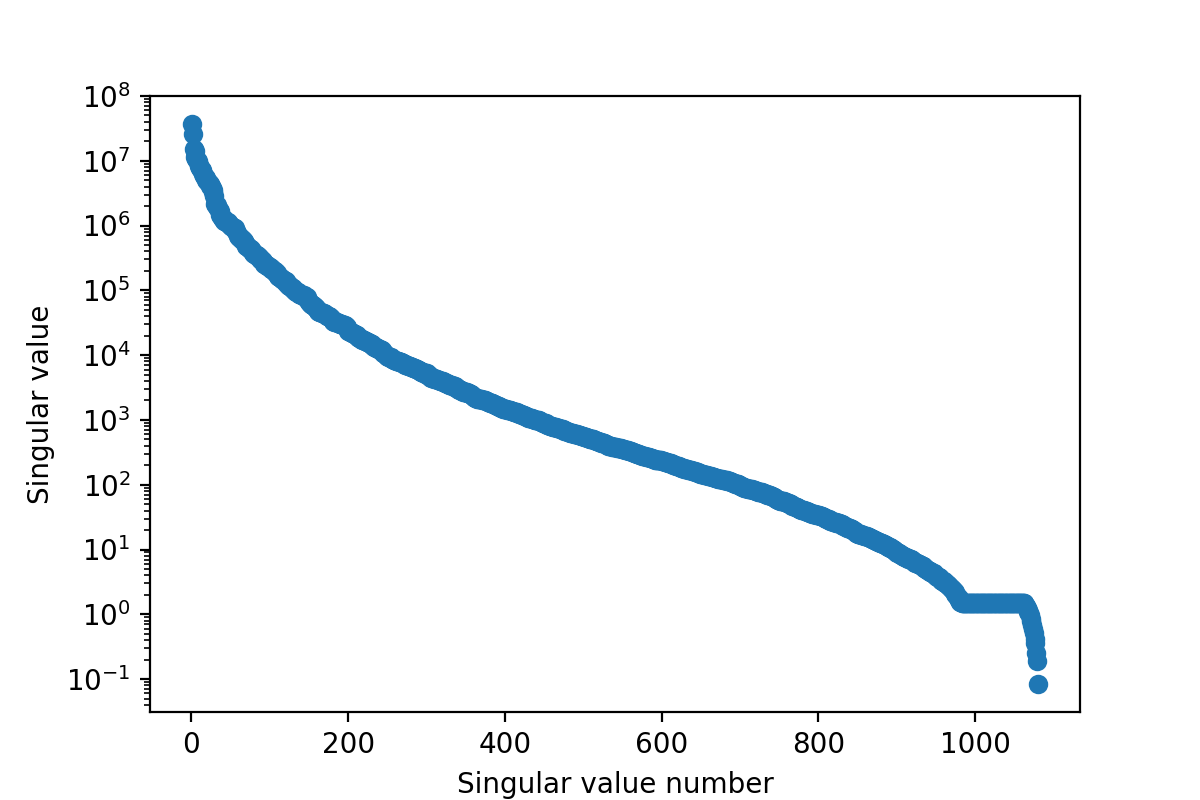

In [881]:
# plot singular values of music pieces
# each singular value represents a feature
plt.figure(201, figsize = (6,4))
#plt.subplot(121)
#plt.scatter(np.arange(1,len(s3)+1), s3)
#plt.xlabel('Singular value number')
#plt.ylabel('Singular value')
#plt.subplot(122)
plt.semilogy(np.arange(1,len(s3)+1), s3, 'o')
plt.xlabel('Singular value number')
plt.ylabel('Singular value')
plt.show()

### Classification - KNN

//anaconda3/envs/workspace/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


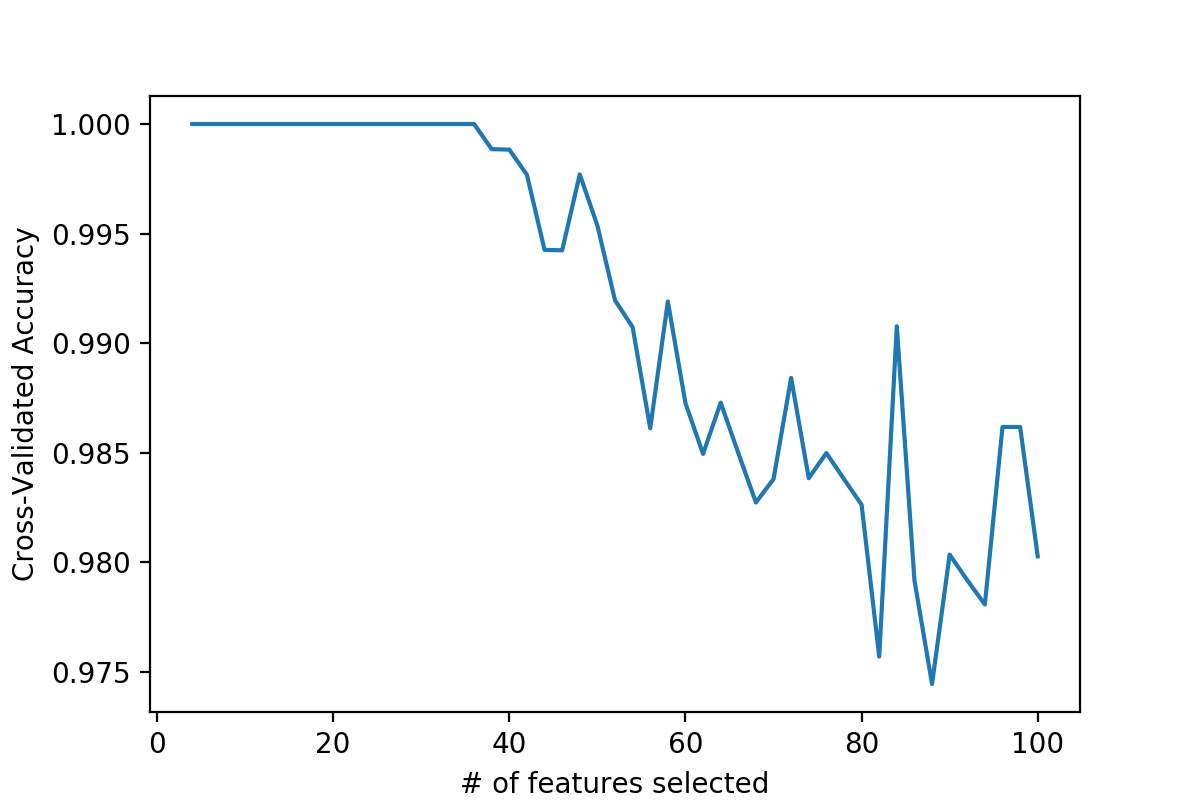

In [882]:
# determine num of features selected
num_list = np.arange(4, 102, 2)
cv_scores = []
for num in num_list:
    range_feature = np.arange(num)
    num_clip = 360
    # train test split
    xtrain, xtest, ytrain, ytest = train_test_gen(vh3.transpose(), range_feature, num_clip)
    knn_model = KNN(n_neighbors = 4)
    score = cross_val_score(knn_model, xtrain, ytrain, cv = 5, scoring = 'accuracy')
    cv_scores.append(score.mean())
    
# plot
plt.figure(226, figsize = (6, 4))
plt.plot(num_list, cv_scores)
plt.xlabel('# of features selected')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

<IPython.core.display.Javascript object>


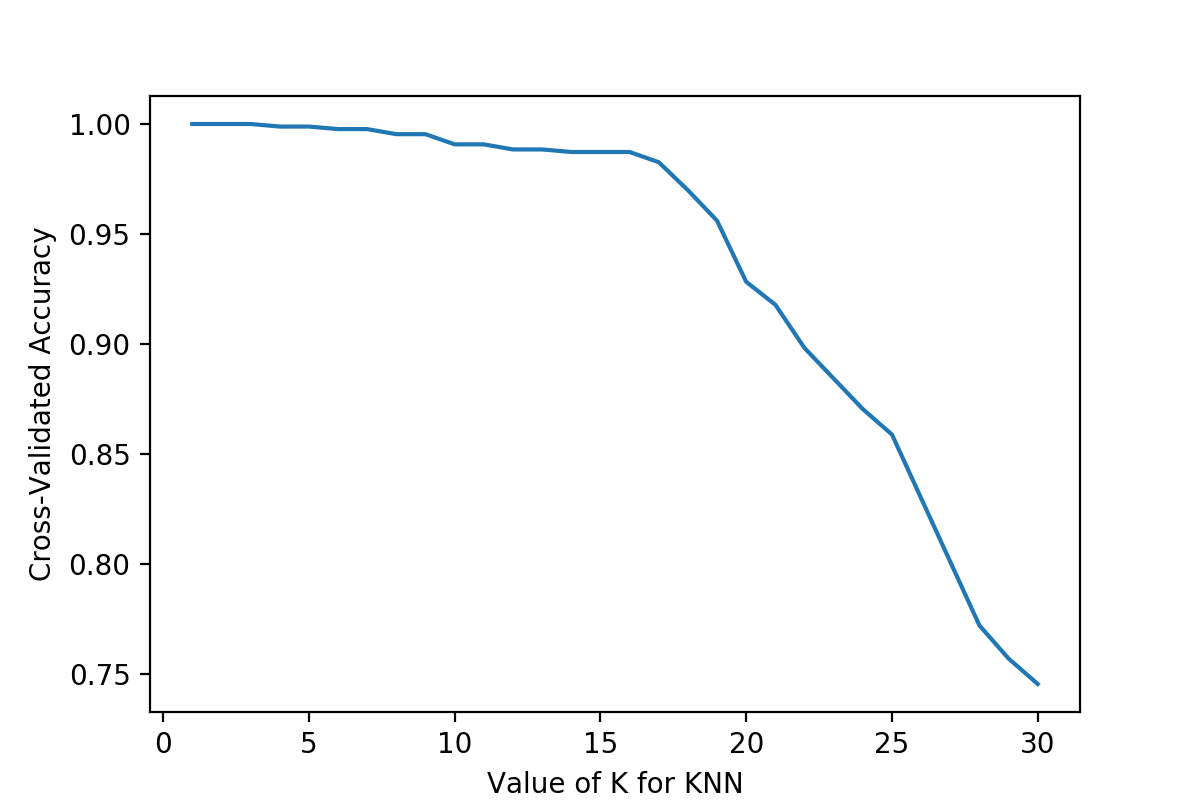

In [760]:
# choose knn parameter
k_scores = []
#k_errors = []
k_range = np.arange(1,31)
for k in k_range:
    knn = KNN(n_neighbors = k)
    scores = cross_val_score(knn, xtrain, ytrain, cv = 6, scoring='accuracy')
    k_scores.append(scores.mean())
    #errors = abs(cross_val_score(knn, xtrain, ytrain, cv = 6, scoring='neg_mean_squared_error'))
    #k_errors.append(errors.mean())
    
plt.figure(222, figsize = (6, 4))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [819]:
# params
range_feature = np.arange(1,20)
num_clip = 360
# train test split
xtrain, xtest, ytrain, ytest = train_test_gen(vh3.transpose(), range_feature, num_clip)

In [820]:
# knn
knn_model = KNN(n_neighbors = 4)
knn_model.fit(xtrain, ytrain)
ytest_pred = knn_model.predict(xtest)

//anaconda3/envs/workspace/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


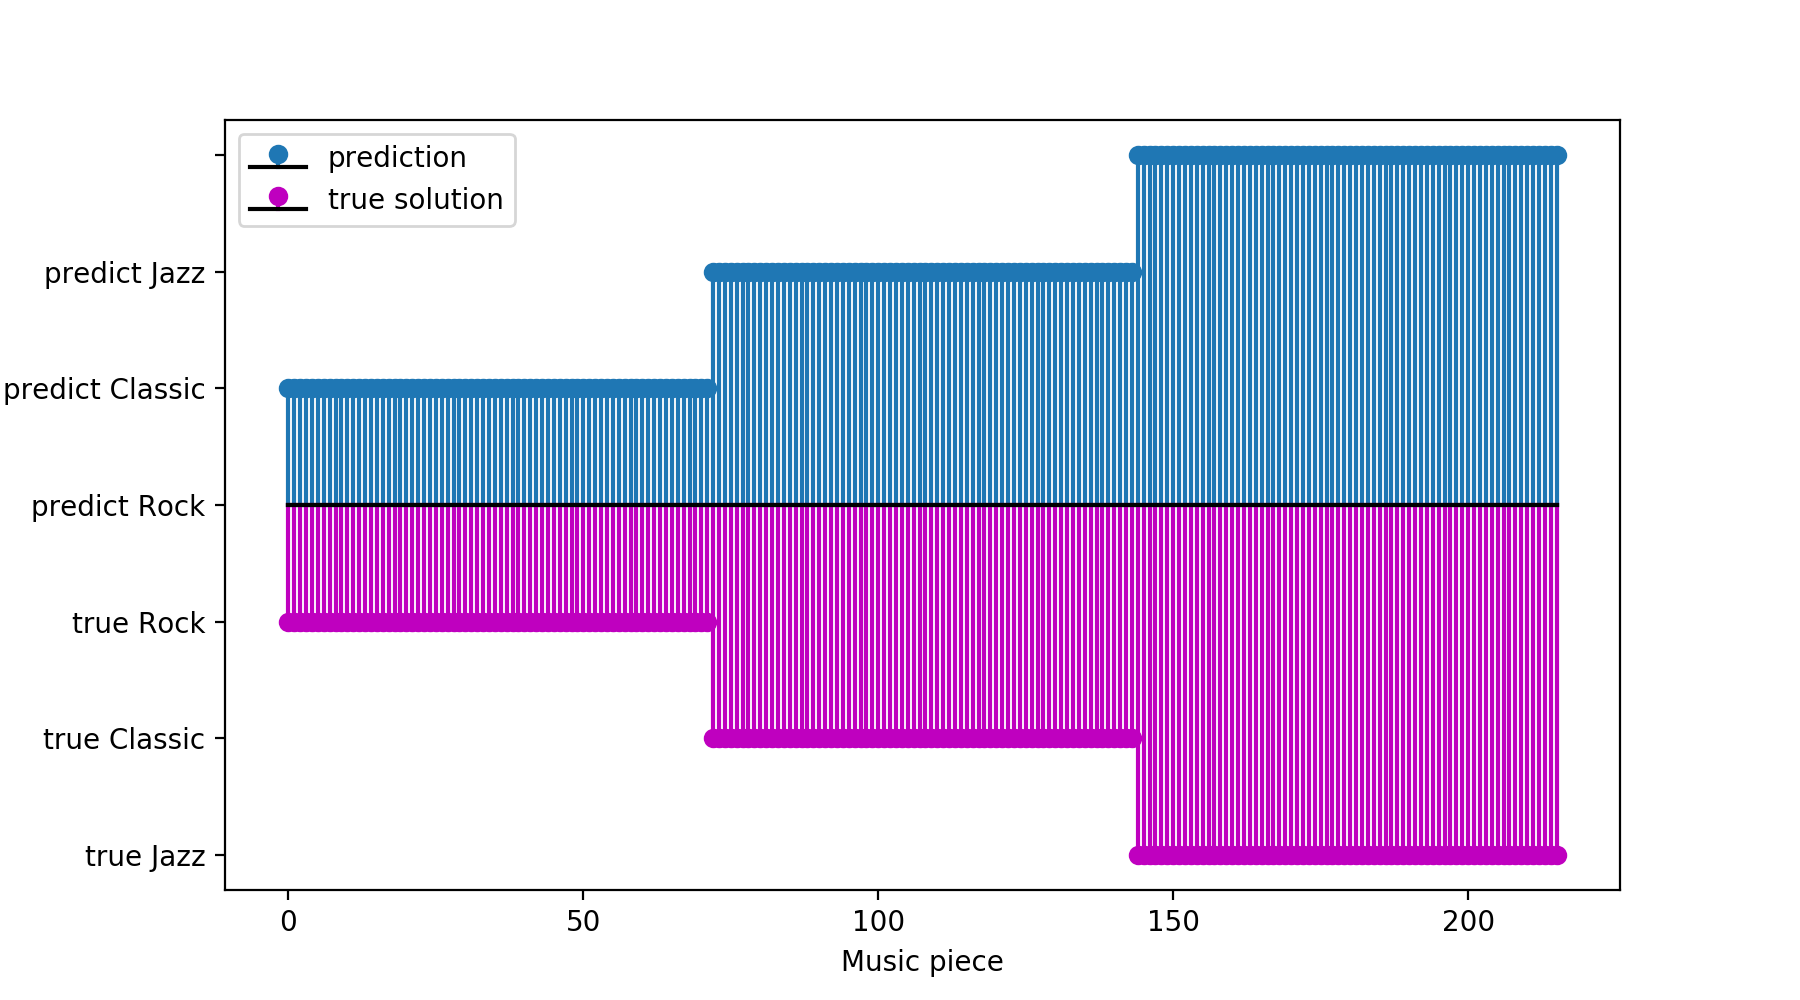

The accuracy of KNN with cross validation is 1.0. 
The accuracy of predicting test set by KNN is 1.0. 


In [768]:
test_score = knn_model.score(xtest, ytest)
cv_score = cross_val_score(knn_model, xtrain, ytrain, cv = 6, scoring='accuracy')

# plot prediction
plt.figure(223, figsize = (9, 5))
plt.stem(ytest_pred, basefmt = 'black', label = 'prediction')
plt.stem(-ytest, linefmt = 'm', markerfmt = 'mo', basefmt = 'black', label = 'true solution')
plt.xlabel('Music piece')
plt.ylabel('class')
plt.yticks(np.arange(-3, 4), ['true Jazz', 'true Classic', 'true Rock', 'predict Rock', 'predict Classic', 'predict Jazz'])
plt.legend()
plt.show()

print('The accuracy of KNN with cross validation is {0}. '.format(cv_score.mean()))
print('The accuracy of predicting test set by KNN is {0}. '.format(test_score))

### Classification - Naive Bayes

//anaconda3/envs/workspace/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


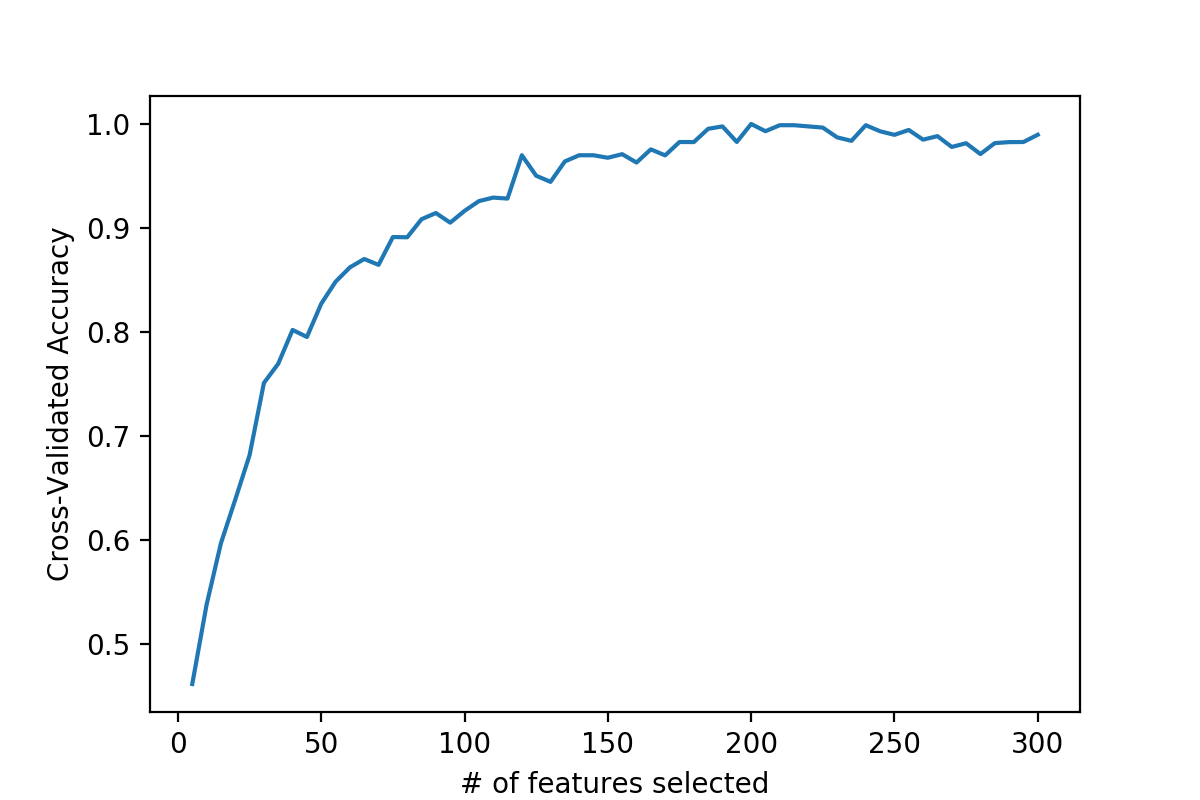

In [771]:
# determine num of features selected
num_list = np.arange(5, 305, 5)
cv_scores = []
for num in num_list:
    range_feature = np.arange(num)
    num_clip = 360
    # train test split
    xtrain, xtest, ytrain, ytest = train_test_gen(vh3.transpose(), range_feature, 360)
    gnb_model = GaussianNB()
    score = cross_val_score(gnb_model, xtrain, ytrain, cv = 5, scoring = 'accuracy')
    cv_scores.append(score.mean())
    
# plot
plt.figure(231, figsize = (6, 4))
plt.plot(num_list, cv_scores)
plt.xlabel('# of features selected')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [772]:
# params
range_feature = np.arange(200)
num_clip = 360
# train test split
xtrain, xtest, ytrain, ytest = train_test_gen(vh3.transpose(), range_feature, num_clip)

In [773]:
gnb_model = GaussianNB()
cross_val_score(gnb_model, xtrain, ytrain, cv = 6, scoring = 'accuracy')

array([1.        , 1.        , 0.99305556, 1.        , 0.98611111,
       0.99305556])

In [774]:
gnb_model = GaussianNB()
gnb_model.fit(xtrain, ytrain)
ytest_pred = gnb_model.predict(xtest)

//anaconda3/envs/workspace/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


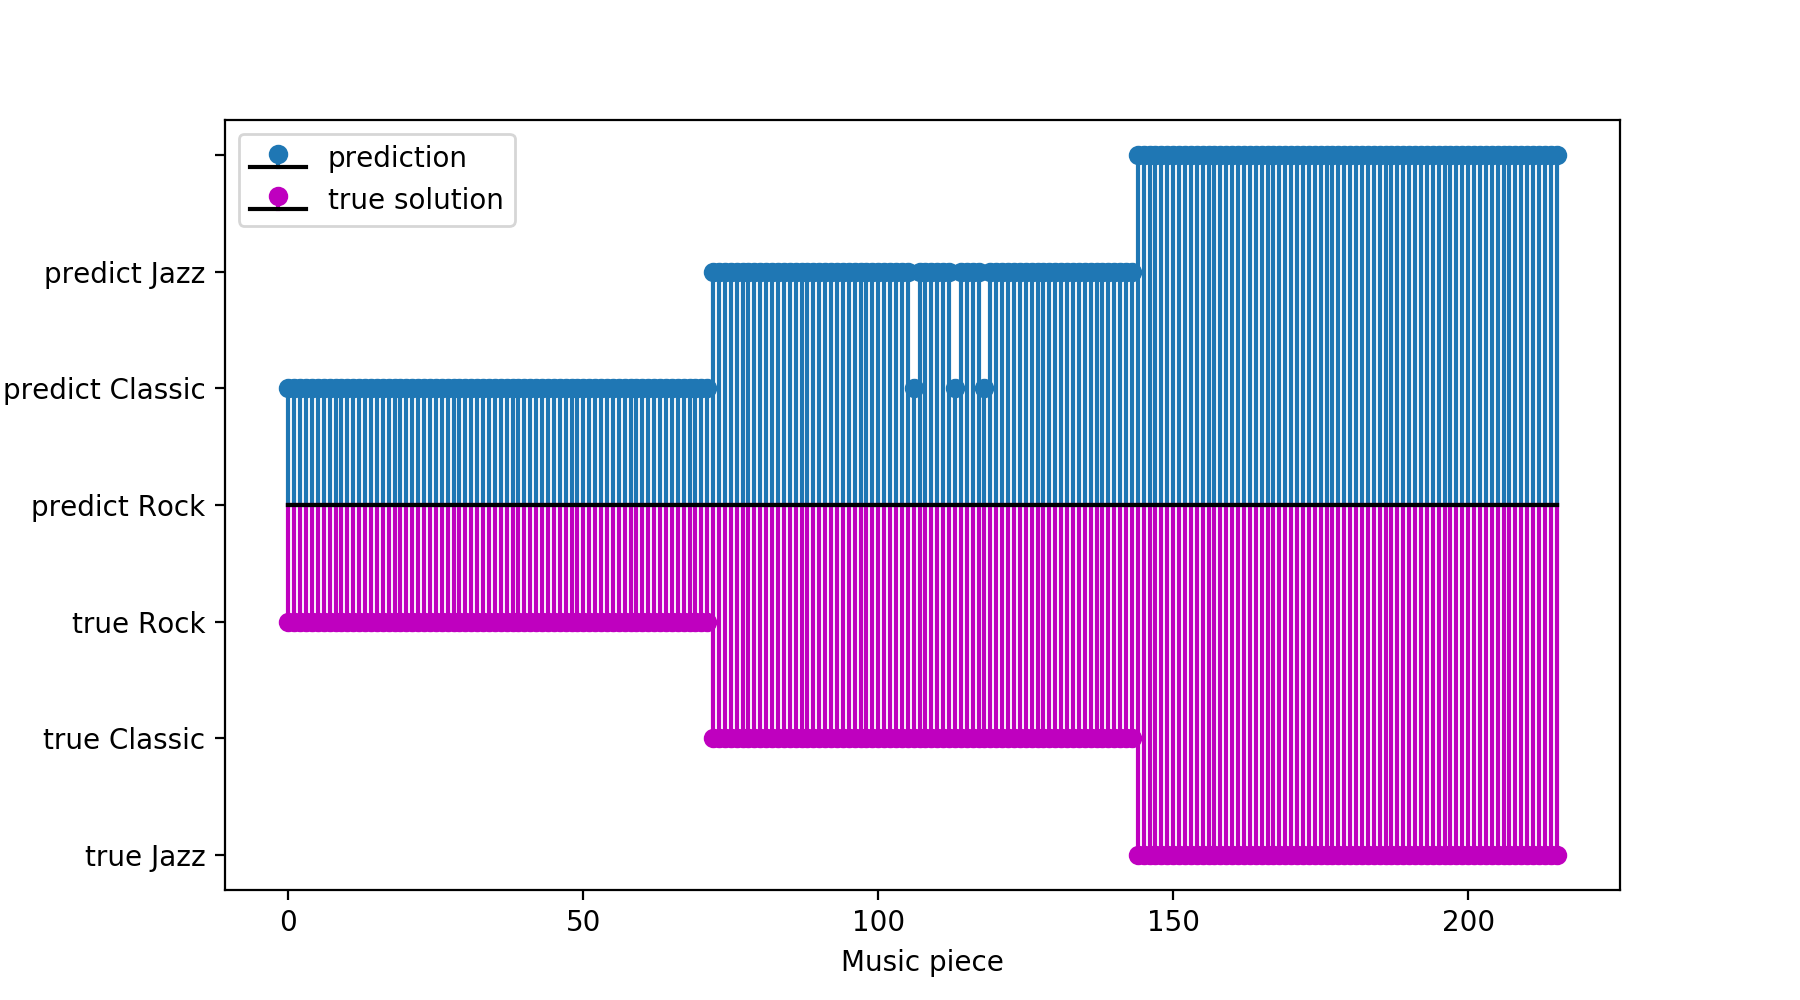

The accuracy of Naive Bayes with cross validation is 0.9953703703703702. 
The accuracy of predicting test set by Naive Bayes is 0.9861111111111112. 


In [775]:
test_score = gnb_model.score(xtest, ytest)
cv_score = cross_val_score(gnb_model, xtrain, ytrain, cv = 6, scoring='accuracy')

# plot prediction
plt.figure(234, figsize = (9, 5))
plt.stem(ytest_pred, basefmt = 'black', label = 'prediction')
plt.stem(-ytest, linefmt = 'm', markerfmt = 'mo', basefmt = 'black', label = 'true solution')
plt.xlabel('Music piece')
plt.ylabel('class')
plt.yticks(np.arange(-3, 4), ['true Jazz', 'true Classic', 'true Rock', 'predict Rock', 'predict Classic', 'predict Jazz'])
plt.legend()
plt.show()

print('The accuracy of Naive Bayes with cross validation is {0}. '.format(cv_score.mean()))
print('The accuracy of predicting test set by Naive Bayes is {0}. '.format(test_score))

### Classification - LDA

//anaconda3/envs/workspace/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


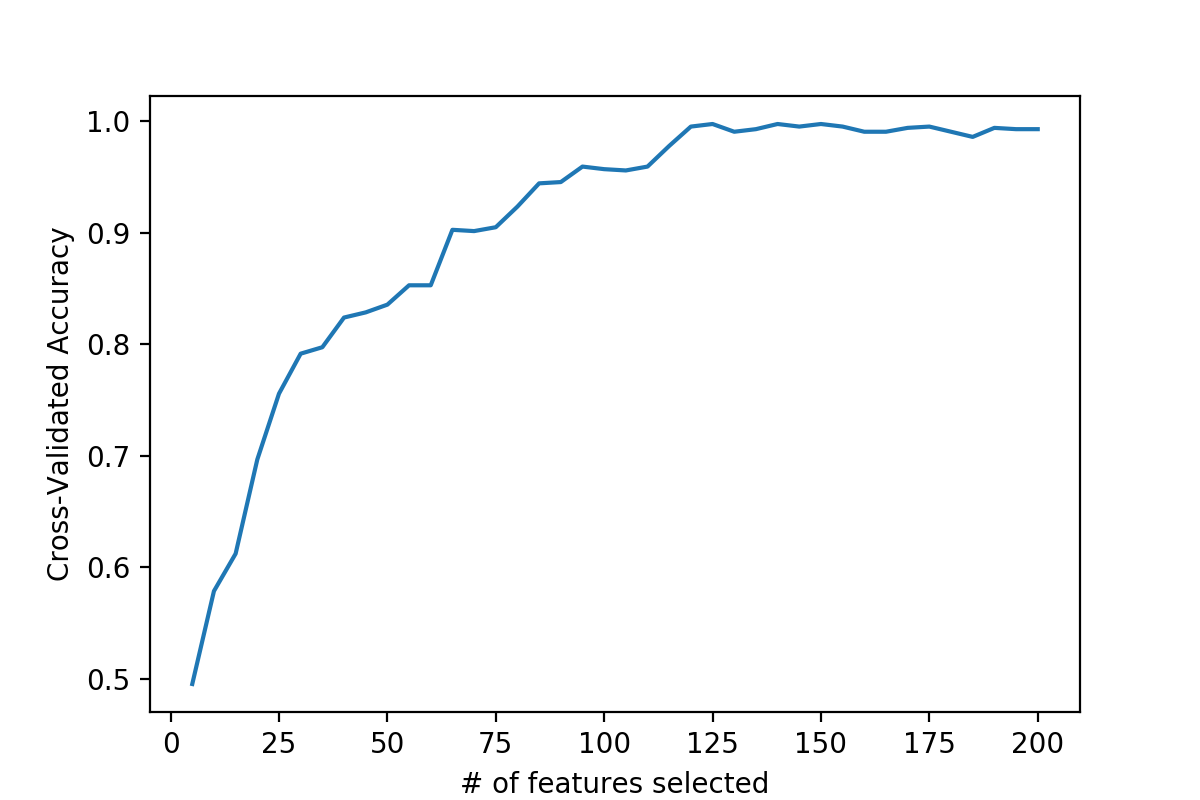

In [779]:
# determine num of features selected
num_list = np.arange(5, 205, 5)
cv_scores = []
for num in num_list:
    range_feature = np.arange(num)
    num_clip = 360
    # train test split
    xtrain, xtest, ytrain, ytest = train_test_gen(vh3.transpose(), range_feature, num_clip)
    lda_model = LDA()
    score = cross_val_score(lda_model, xtrain, ytrain, cv = 6, scoring = 'accuracy')
    cv_scores.append(score.mean())
    
# plot
plt.figure(241, figsize = (6, 4))
plt.plot(num_list, cv_scores)
plt.xlabel('# of features selected')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [780]:
# params
range_feature = np.arange(125)
num_clip = 360
# train test split
xtrain, xtest, ytrain, ytest = train_test_gen(vh3.transpose(), range_feature, num_clip)

In [781]:
lda_model = LDA()
cross_val_score(lda_model, xtrain, ytrain, cv = 6, scoring = 'accuracy')

array([1.        , 1.        , 0.98611111, 1.        , 0.99305556,
       1.        ])

In [782]:
lda_model = LDA()
lda_model.fit(xtrain, ytrain)
ytest_pred = lda_model.predict(xtest)

//anaconda3/envs/workspace/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


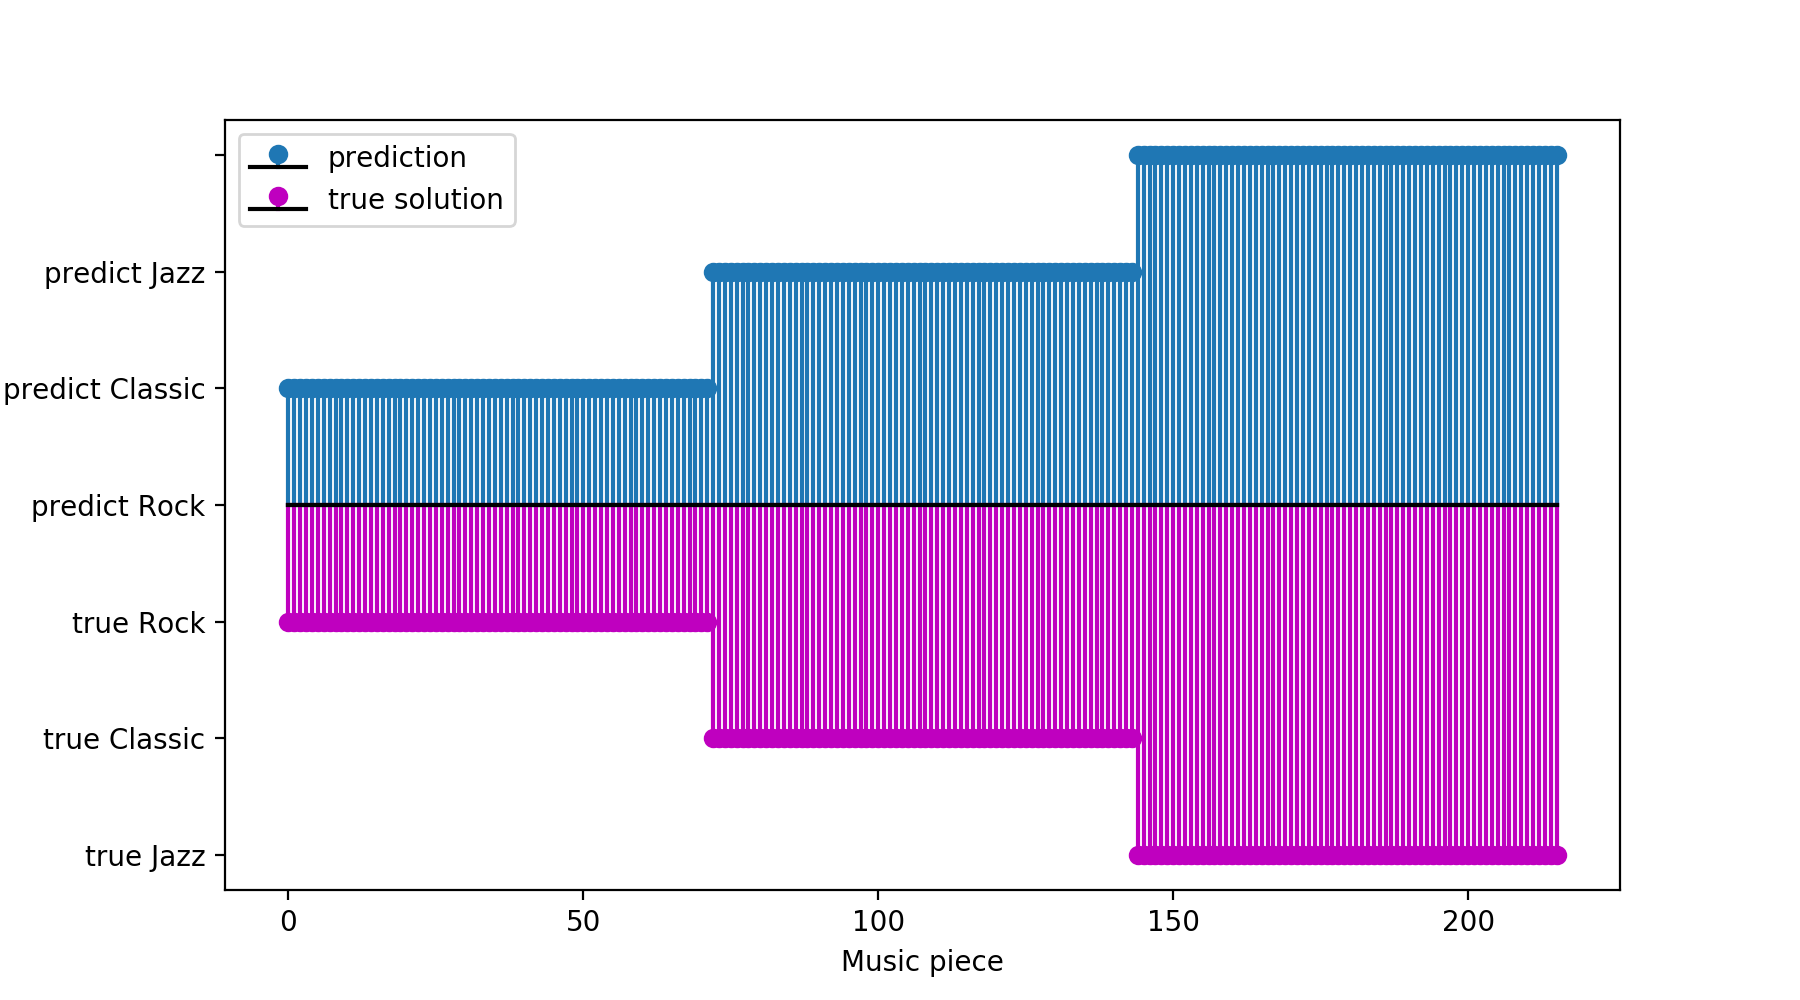

The accuracy of LDA with cross validation is 0.9965277777777778. 
The accuracy of predicting test set by LDA is 1.0. 


In [784]:
test_score = lda_model.score(xtest, ytest)
cv_score = cross_val_score(lda_model, xtrain, ytrain, cv = 6, scoring='accuracy')

# plot prediction
plt.figure(245, figsize = (9, 5))
plt.stem(ytest_pred, basefmt = 'black', label = 'prediction')
plt.stem(-ytest, linefmt = 'm', markerfmt = 'mo', basefmt = 'black', label = 'true solution')
plt.xlabel('Music piece')
plt.ylabel('class')
plt.yticks(np.arange(-3, 4), ['true Jazz', 'true Classic', 'true Rock', 'predict Rock', 'predict Classic', 'predict Jazz'])
plt.legend()
plt.show()

print('The accuracy of LDA with cross validation is {0}. '.format(cv_score.mean()))
print('The accuracy of predicting test set by LDA is {0}. '.format(test_score))

### Classification - SVM

//anaconda3/envs/workspace/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


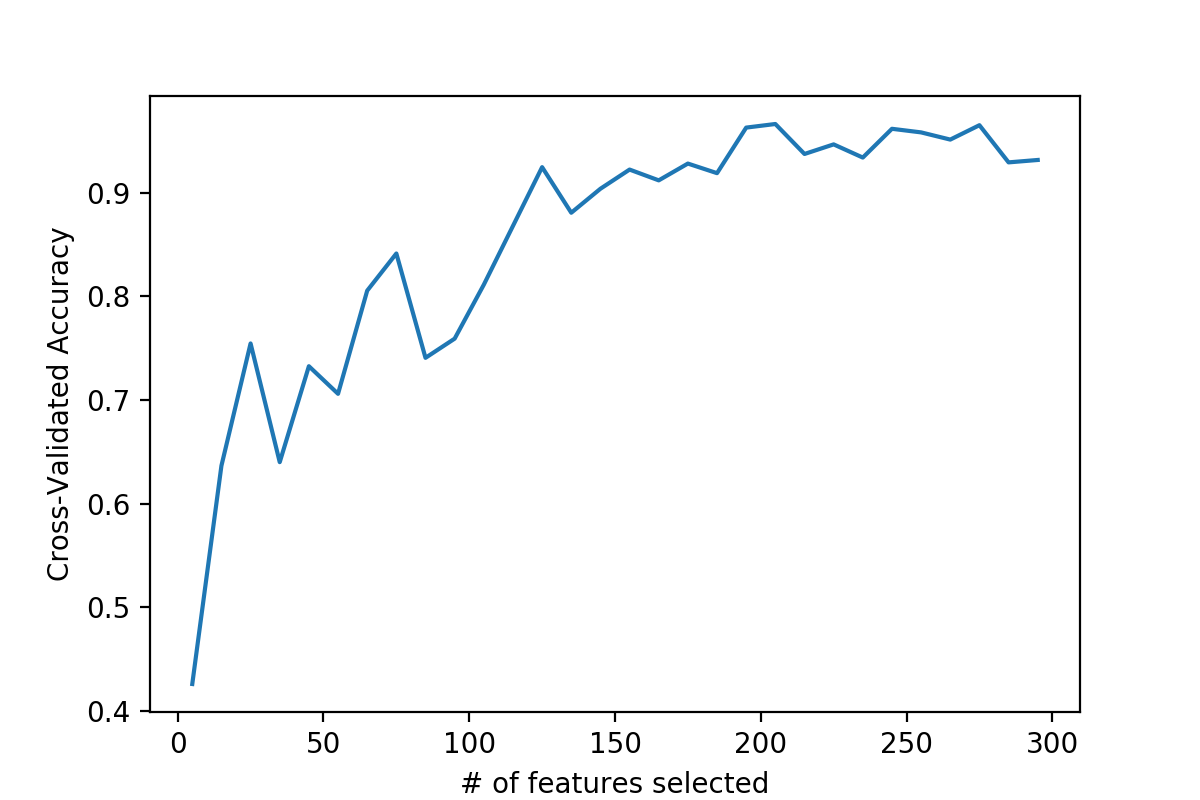

In [787]:
# determine num of features selected
num_list = np.arange(5, 305, 10)
cv_scores = []
for num in num_list:
    range_feature = np.arange(num)
    num_clip = 360
    # train test split
    xtrain, xtest, ytrain, ytest = train_test_gen(vh3.transpose(), range_feature, num_clip)
    svm_model = svm.SVC(gamma = 'auto')
    score = cross_val_score(svm_model, xtrain, ytrain, cv = 6, scoring = 'accuracy')
    cv_scores.append(score.mean())
    
# plot
plt.figure(256, figsize = (6, 4))
plt.plot(num_list, cv_scores)
plt.xlabel('# of features selected')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [790]:
# params
range_feature = np.arange(250)
num_clip = 360
# train test split
xtrain, xtest, ytrain, ytest = train_test_gen(vh3.transpose(), range_feature, num_clip)

In [791]:
svm_model = svm.SVC(gamma = 'auto')
cross_val_score(svm_model, xtrain, ytrain, cv = 6, scoring = 'accuracy')

array([0.94444444, 0.96527778, 0.97222222, 1.        , 0.90972222,
       0.95138889])

In [792]:
svm_model = svm.SVC(gamma = 'auto')
svm_model.fit(xtrain, ytrain)
ytest_pred = svm_model.predict(xtest)

//anaconda3/envs/workspace/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


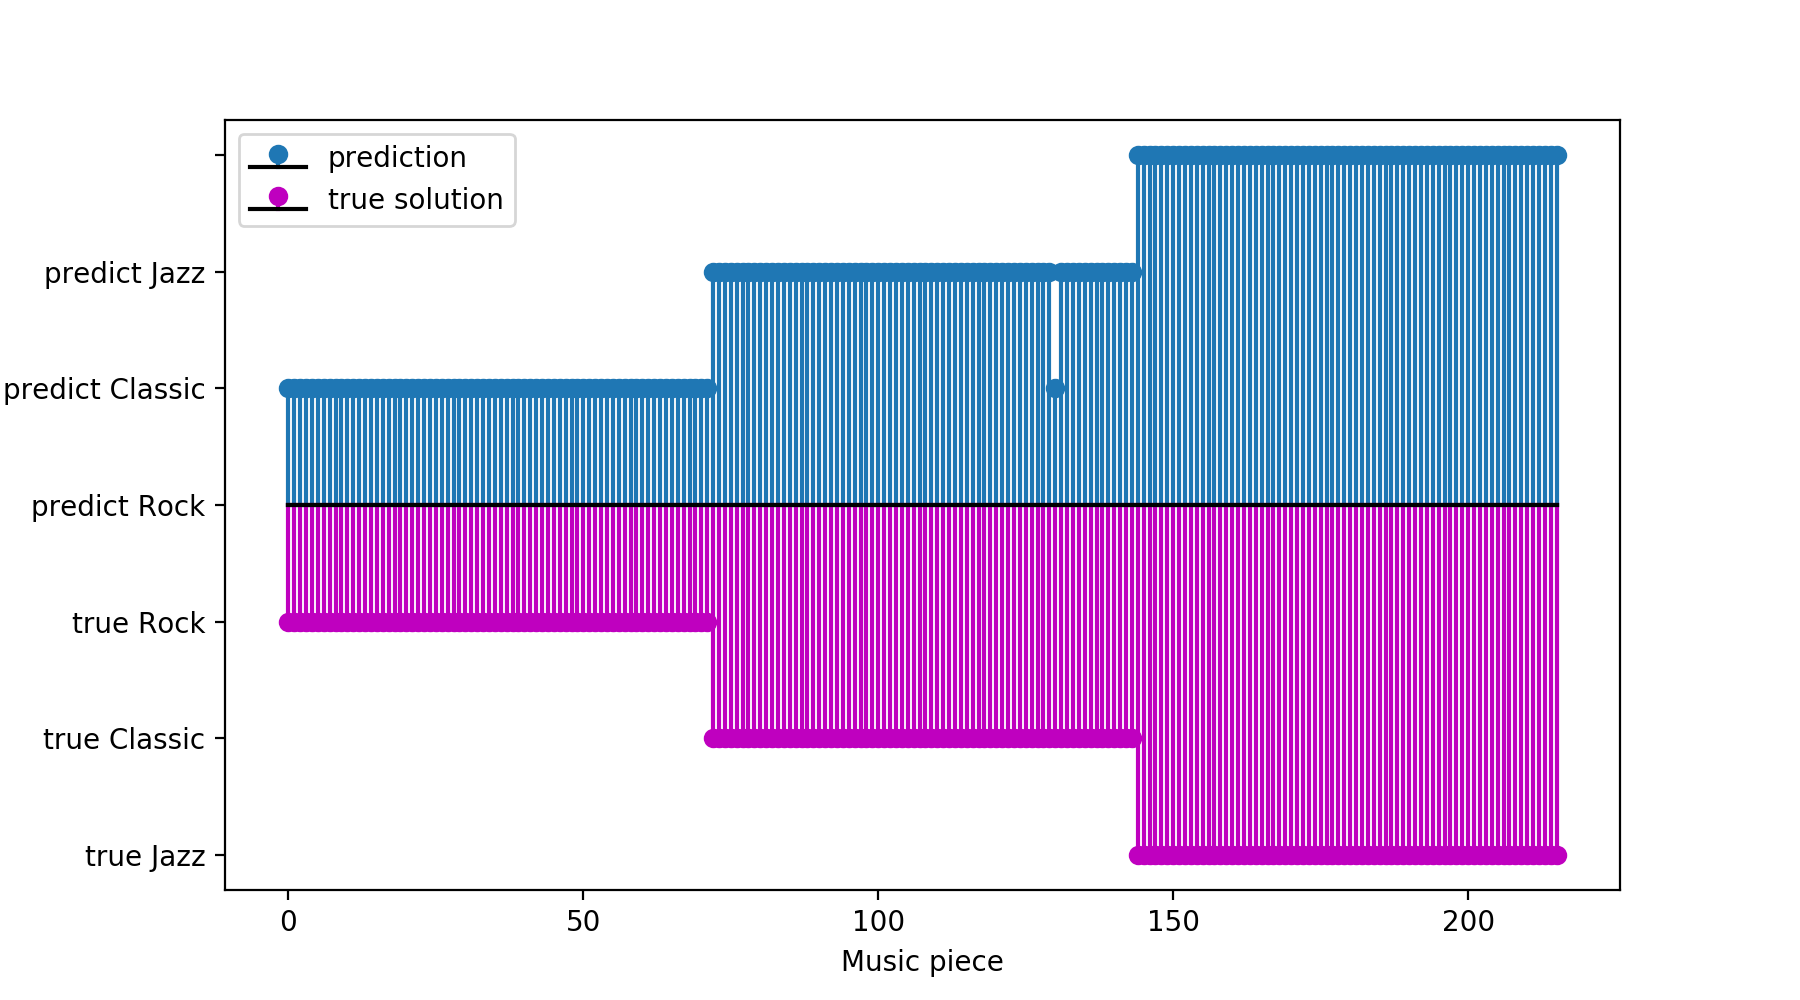

The accuracy of LDA with cross validation is 0.9571759259259259. 
The accuracy of predicting test set by LDA is 0.9953703703703703. 


In [793]:
test_score = svm_model.score(xtest, ytest)
cv_score = cross_val_score(svm_model, xtrain, ytrain, cv = 6, scoring='accuracy')

# plot prediction
plt.figure(266, figsize = (9, 5))
plt.stem(ytest_pred, basefmt = 'black', label = 'prediction')
plt.stem(-ytest, linefmt = 'm', markerfmt = 'mo', basefmt = 'black', label = 'true solution')
plt.xlabel('Music piece')
plt.ylabel('class')
plt.yticks(np.arange(-3, 4), ['true Jazz', 'true Classic', 'true Rock', 'predict Rock', 'predict Classic', 'predict Jazz'])
plt.legend()
plt.show()

print('The accuracy of LDA with cross validation is {0}. '.format(cv_score.mean()))
print('The accuracy of predicting test set by LDA is {0}. '.format(test_score))

### Test on an arbitrary 5-sec music clip

In [841]:
# generate a 5-sec music clip
#testfs, testdata = wavfile.read('dataset/Oasis/Supersonic - Oasis.wav')
testfs, testdata = wavfile.read('dataset/Pearl_Jam/Yellow LedBetter - Pearl Jam.wav')
testdata = testdata.mean(axis = 1)
testdata = data_crop(testdata)
test5sec = data_5sec_init(testfs, testdata, 1)
spec5sec = genre_spec(test5sec)
# this is in genre 'rock'

$$A = U\Sigma V^*$$
$$\Sigma^{-1}U^*A = V^*$$

In [842]:
# project onto feature space
vh5spec = np.linalg.multi_dot((np.diag(1/s3), u3.transpose(), spec5sec))

In [843]:
# knn prediction
range_feat = np.arange(1,20)
knn_model.predict(vh5spec[range_feat].transpose())
# we can see that the prediction is not rock (class 1)

array([2.])

In [844]:
# gnb prediction
range_feat = np.arange(200)
gnb_model.predict(vh5spec[range_feat].transpose())
# we can see that the prediction is rock (class 1)

array([1.])

In [845]:
# lda prediction
range_feat = np.arange(125)
lda_model.predict(vh5spec[range_feat].transpose())
# we can see that the prediction is rock (class 1)

array([1.])

In [846]:
# svm prediction
range_feat = np.arange(250)
svm_model.predict(vh5spec[range_feat].transpose())
# we can see that the prediction is not rock (class 1)

array([3.])